Numeric features used: ['building_volume', 'population_density', 'road_density', 'greenhouse_coverage']
Categorical features used: ['city']

=== Baseline performance (trained on log1p(y), reported in original units) ===
               split     R2      MAE      RMSE
Random split (80/20) 0.1545 195.4372 1116.5202
OOB R2 (train, approximate): 0.6355


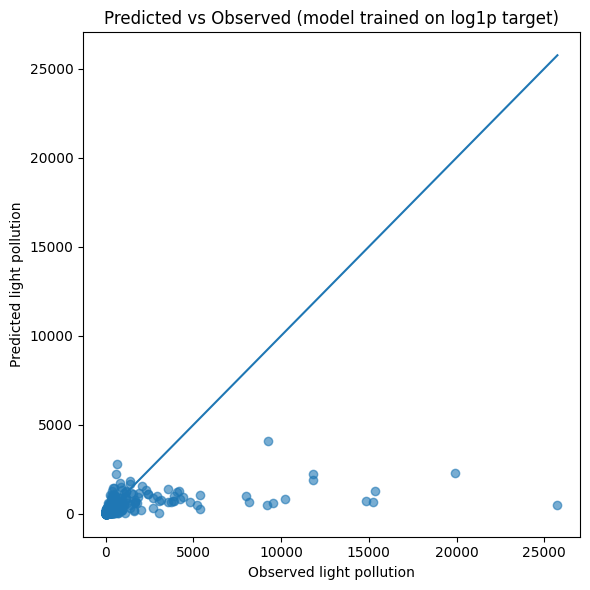

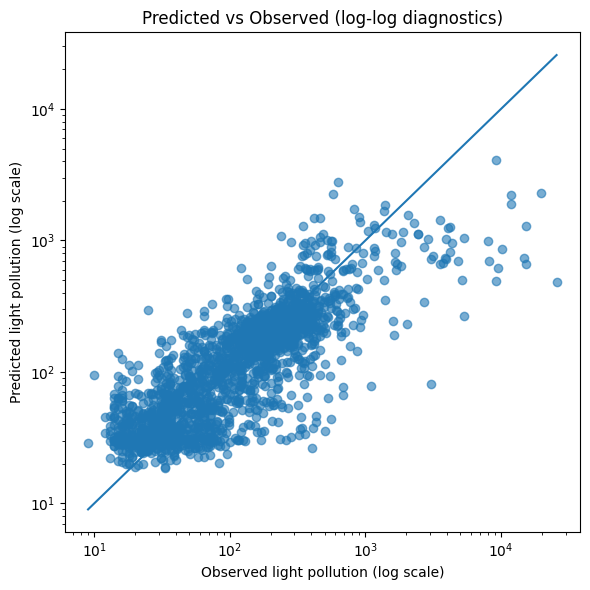


=== Top 15 feature importances ===
            feature  importance
    building_volume    0.601415
       road_density    0.156333
greenhouse_coverage    0.135720
 population_density    0.076650
      city_Den Haag    0.025364
     city_Amsterdam    0.004518


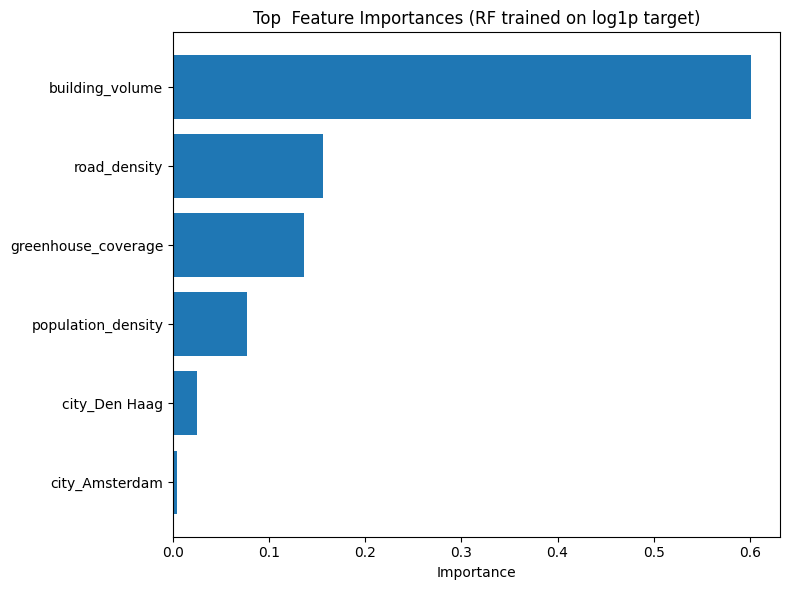


=== City-wise transfer performance (trained on log1p target) ===
               split      R2      MAE      RMSE
Amsterdam → Den Haag -0.0157 407.5456 1805.6150
Den Haag → Amsterdam  0.2925  79.8784  146.8218


In [ ]:
#With greenhouses Log transformed
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt

# -----------------------
# Load data (KEEP greenhouse columns)
# -----------------------
df = pd.read_csv("light_pollution_data.csv")

X = df.drop(columns=["light_pollution", "fid"])
y = df["light_pollution"]

# -----------------------
# Column types
# -----------------------
numeric_features = [
    "building_volume",
    "population_density",
    "road_density",
]

# Add greenhouse-related numeric columns automatically (case-insensitive)
greenhouse_cols = [c for c in X.columns if "greenhouse" in c.lower()]
numeric_features = list(dict.fromkeys(numeric_features + greenhouse_cols))  # keep unique order

categorical_features = ["city"]

# Sanity check
missing_num = [c for c in numeric_features if c not in X.columns]
missing_cat = [c for c in categorical_features if c not in X.columns]
if missing_num or missing_cat:
    raise ValueError(f"Missing columns. numeric missing={missing_num}, categorical missing={missing_cat}")

print("Numeric features used:", numeric_features)
print("Categorical features used:", categorical_features)

# -----------------------
# Preprocessing
# -----------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

# -----------------------
# Base model (Random Forest)
# -----------------------
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    oob_score=True,
)

base_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf)
])

# -----------------------
# Log transform the TARGET using TransformedTargetRegressor
# -----------------------
log_transformer = FunctionTransformer(
    func=np.log1p,     # log(1 + y)
    inverse_func=np.expm1,  # exp(y) - 1
    validate=False
)

model = TransformedTargetRegressor(
    regressor=base_pipeline,
    transformer=log_transformer
)

# -----------------------
# Helper: pretty metrics
# -----------------------
def regression_report(y_true, y_pred, label=""):
    return pd.DataFrame([{
        "split": label,
        "R2": r2_score(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred))
    }])

# -----------------------
# A) Normal random split (baseline)
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

report_baseline = regression_report(y_test, y_pred, label="Random split (80/20)")

# OOB score is on the underlying RF inside the pipeline inside the TTR
oob = model.regressor_.named_steps["model"].oob_score_

print("\n=== Baseline performance (trained on log1p(y), reported in original units) ===")
print(report_baseline.to_string(index=False, float_format=lambda v: f"{v:0.4f}"))
print(f"OOB R2 (train, approximate): {oob:0.4f}")

# Plot predicted vs observed (original units)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
mn, mx = float(np.min(y_test)), float(np.max(y_test))
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Observed light pollution")
plt.ylabel("Predicted light pollution")
plt.title("Predicted vs Observed (model trained on log1p target)")
plt.tight_layout()
plt.show()

# Optional: ALSO show log-log plot for diagnostics
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xscale("log")
plt.yscale("log")
mn_pos = max(float(np.min(y_test[y_test > 0])), 1e-6) if np.any(y_test > 0) else 1e-6
mx_pos = float(np.max(y_test))
plt.plot([mn_pos, mx_pos], [mn_pos, mx_pos])
plt.xlabel("Observed light pollution (log scale)")
plt.ylabel("Predicted light pollution (log scale)")
plt.title("Predicted vs Observed (log-log diagnostics)")
plt.tight_layout()
plt.show()

# -----------------------
# Feature importances (from fitted underlying RF)
# -----------------------
# Access fitted preprocessor + encoder inside model.regressor_
pre = model.regressor_.named_steps["preprocessor"]
cat_encoder = pre.named_transformers_["cat"].named_steps["encoder"]

cat_names = list(cat_encoder.get_feature_names_out(categorical_features))
feature_names = numeric_features + cat_names

importances = model.regressor_.named_steps["model"].feature_importances_

importance_df = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
      .sort_values("importance", ascending=False)
      .reset_index(drop=True)
)

print("\n=== Top 15 feature importances ===")
print(importance_df.head(15).to_string(index=False, float_format=lambda v: f"{v:0.6f}"))

# Optional: plot top 15
topk = importance_df.head(15).iloc[::-1]
plt.figure(figsize=(8,6))
plt.barh(topk["feature"], topk["importance"])
plt.xlabel("Importance")
plt.title("Top  Feature Importances (RF trained on log1p target)")
plt.tight_layout()
plt.show()

# -----------------------
# B) City-to-city generalization
# -----------------------
def train_on_city_test_on_city(train_city, test_city):
    train_df = df[df["city"] == train_city]
    test_df  = df[df["city"] == test_city]

    X_tr = train_df.drop(columns=["light_pollution", "fid"])
    y_tr = train_df["light_pollution"]

    X_te = test_df.drop(columns=["light_pollution", "fid"])
    y_te = test_df["light_pollution"]

    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)  # prediction is automatically back-transformed to original units
    return regression_report(y_te, pred, label=f"{train_city} → {test_city}")

report_city_1 = train_on_city_test_on_city("Amsterdam", "Den Haag")
report_city_2 = train_on_city_test_on_city("Den Haag", "Amsterdam")

report_citywise = pd.concat([report_city_1, report_city_2], ignore_index=True)

print("\n=== City-wise transfer performance (trained on log1p target) ===")
print(report_citywise.to_string(index=False, float_format=lambda v: f"{v:0.4f}"))


Removed greenhouse columns: ['greenhouse_coverage']

=== Random Split Performance (NO greenhouses, log1p target) ===
Metric     Value
    R²    0.0866
   MAE  203.8262
  RMSE 1160.5143
OOB R²: 0.5822


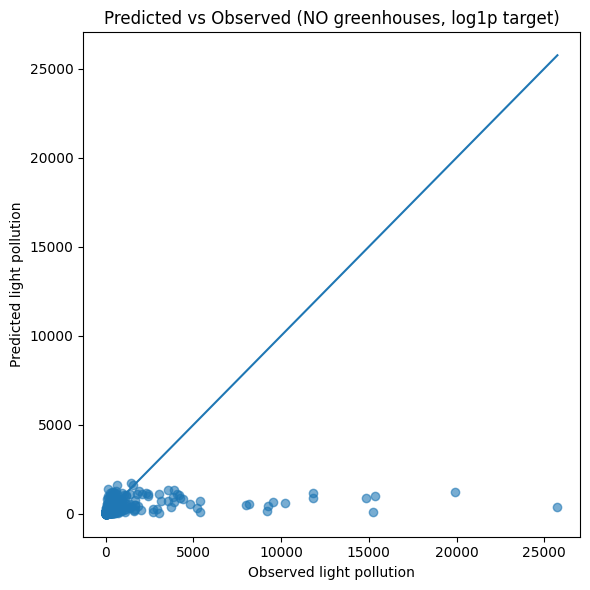

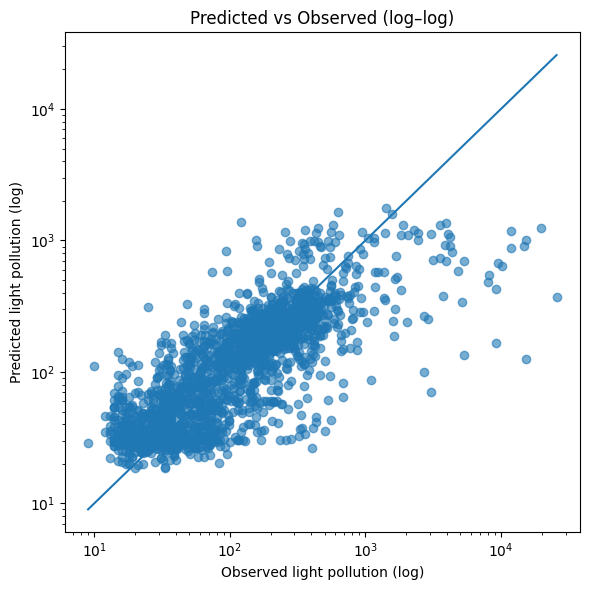


=== Top 10 Features (NO greenhouses, log1p target) ===
           feature  importance
   building_volume    0.649450
      road_density    0.204836
population_density    0.090239
     city_Den Haag    0.039933
    city_Amsterdam    0.015542

=== City-to-City Transfer (NO greenhouses, log1p target) ===
        Train → Test      R²      MAE      RMSE
Amsterdam → Den Haag -0.0216 412.1426 1810.7859
Den Haag → Amsterdam -0.0794 102.4945  181.3437


In [15]:
#without greenhouses log transformed
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt

# -----------------------
# Load data (NO greenhouses)
# -----------------------
df = pd.read_csv("light_pollution_data.csv")

greenhouse_cols = [c for c in df.columns if "greenhouse" in c.lower()]
print("Removed greenhouse columns:", greenhouse_cols)

df_nog = df.drop(columns=greenhouse_cols)

X = df_nog.drop(columns=["light_pollution", "fid"])
y = df_nog["light_pollution"]

# -----------------------
# Feature types
# -----------------------
numeric_features = [
    "building_volume",
    "population_density",
    "road_density"
]

categorical_features = ["city"]

# -----------------------
# Preprocessing
# -----------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# -----------------------
# Random Forest
# -----------------------
rf = RandomForestRegressor(
    n_estimators=300,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    oob_score=True
)

base_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf)
])

# -----------------------
# Log1p target transformation
# -----------------------
log_transformer = FunctionTransformer(
    func=np.log1p,
    inverse_func=np.expm1,
    validate=False
)

model = TransformedTargetRegressor(
    regressor=base_pipeline,
    transformer=log_transformer
)

# -----------------------
# Random split evaluation
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

results = pd.DataFrame({
    "Metric": ["R²", "MAE", "RMSE"],
    "Value": [
        r2_score(y_test, y_pred),
        mean_absolute_error(y_test, y_pred),
        np.sqrt(mean_squared_error(y_test, y_pred))
    ]
})

print("\n=== Random Split Performance (NO greenhouses, log1p target) ===")
print(results.to_string(index=False, float_format=lambda v: f"{v:.4f}"))

# OOB score from underlying RF
print(f"OOB R²: {model.regressor_.named_steps['model'].oob_score_:.4f}")

# -----------------------
# Predicted vs Observed (linear scale)
# -----------------------
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Observed light pollution")
plt.ylabel("Predicted light pollution")
plt.title("Predicted vs Observed (NO greenhouses, log1p target)")
plt.tight_layout()
plt.show()

# Optional: log–log diagnostic plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xscale("log")
plt.yscale("log")
mn = max(y_test[y_test > 0].min(), 1e-6)
mx = y_test.max()
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Observed light pollution (log)")
plt.ylabel("Predicted light pollution (log)")
plt.title("Predicted vs Observed (log–log)")
plt.tight_layout()
plt.show()

# -----------------------
# Feature importance
# -----------------------
pre = model.regressor_.named_steps["preprocessor"]
cat_names = (
    pre.named_transformers_["cat"]
    .named_steps["encoder"]
    .get_feature_names_out(categorical_features)
)

feature_names = numeric_features + list(cat_names)
importances = model.regressor_.named_steps["model"].feature_importances_

importance_df = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

print("\n=== Top 10 Features (NO greenhouses, log1p target) ===")
print(importance_df.head(10).to_string(index=False, float_format=lambda v: f"{v:.6f}"))

# -----------------------
# City-to-city transfer
# -----------------------
def city_transfer(train_city, test_city):
    train = df_nog[df_nog["city"] == train_city]
    test  = df_nog[df_nog["city"] == test_city]

    X_tr = train.drop(columns=["light_pollution", "fid"])
    y_tr = train["light_pollution"]
    X_te = test.drop(columns=["light_pollution", "fid"])
    y_te = test["light_pollution"]

    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)

    return {
        "Train → Test": f"{train_city} → {test_city}",
        "R²": r2_score(y_te, pred),
        "MAE": mean_absolute_error(y_te, pred),
        "RMSE": np.sqrt(mean_squared_error(y_te, pred))
    }

city_results = pd.DataFrame([
    city_transfer("Amsterdam", "Den Haag"),
    city_transfer("Den Haag", "Amsterdam")
])

print("\n=== City-to-City Transfer (NO greenhouses, log1p target) ===")
print(city_results.to_string(index=False, float_format=lambda v: f"{v:.4f}"))


Numeric features used: ['building_volume', 'population_density', 'road_density', 'greenhouse_coverage']
Categorical features used: ['city']

=== Baseline performance ===
               split     R2      MAE      RMSE
Random split (80/20) 0.3076 221.1385 1010.4156
OOB R2 (train, approximate): 0.3095


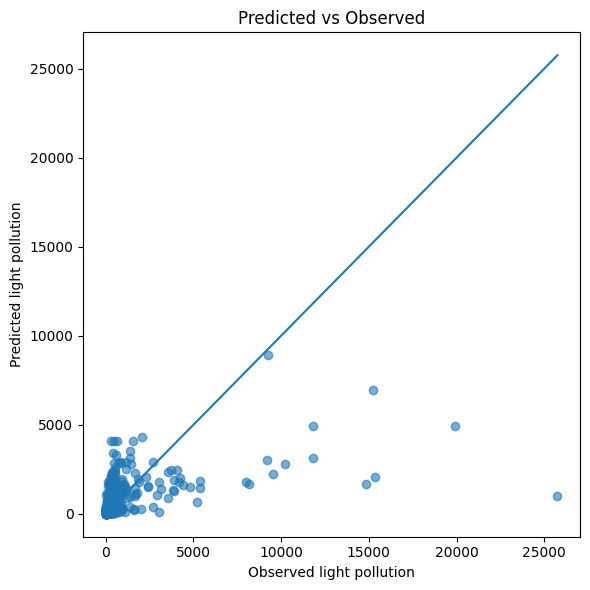


=== Top 15 feature importances ===
            feature  importance
greenhouse_coverage    0.617169
       road_density    0.154141
 population_density    0.146368
    building_volume    0.080520
     city_Amsterdam    0.000968
      city_Den Haag    0.000834


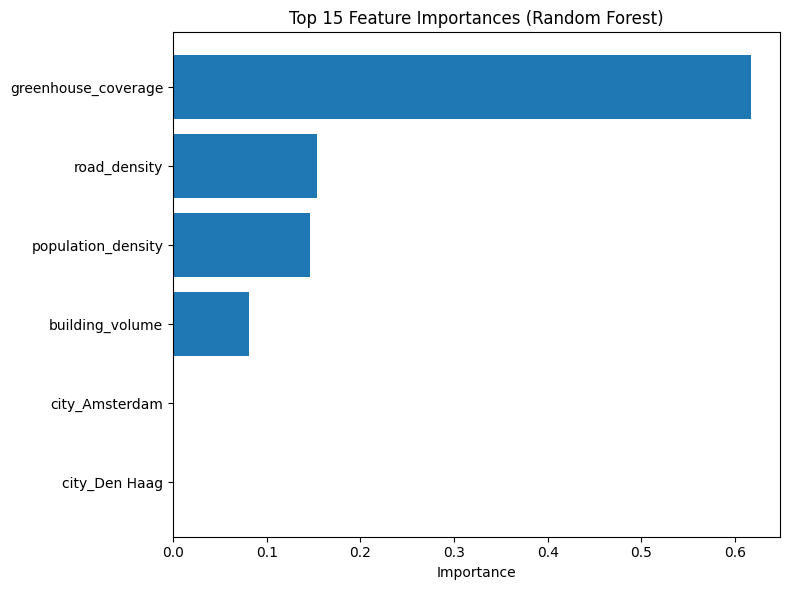


=== City-wise transfer performance ===
               split      R2      MAE      RMSE
Amsterdam → Den Haag  0.0563 391.0909 1740.4072
Den Haag → Amsterdam -0.2398 122.6375  194.3567


In [ ]:
#with greenhouses baseline
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt

# -----------------------
# Load data (KEEP greenhouse columns)
# -----------------------
df = pd.read_csv("light_pollution_data.csv")

# Define target and predictors
X = df.drop(columns=["light_pollution", "fid"])
y = df["light_pollution"]

# -----------------------
# Column types
# -----------------------
numeric_features = [
    "building_volume",
    "population_density",
    "road_density",
]

# Add any greenhouse-related numeric columns automatically (case-insensitive)
greenhouse_cols = [c for c in X.columns if "greenhouse" in c.lower()]
numeric_features = list(dict.fromkeys(numeric_features + greenhouse_cols))  # unique-preserving

categorical_features = ["city"]

# (Optional) sanity check: columns missing?
missing_num = [c for c in numeric_features if c not in X.columns]
missing_cat = [c for c in categorical_features if c not in X.columns]
if missing_num or missing_cat:
    raise ValueError(f"Missing columns. numeric missing={missing_num}, categorical missing={missing_cat}")

print("Numeric features used:", numeric_features)
print("Categorical features used:", categorical_features)

# -----------------------
# Preprocessing
# -----------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

# -----------------------
# Random Forest model
# -----------------------
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    oob_score=True,   # helpful quick diagnostic (works with bootstrap=True, which is default)
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf)
])

# -----------------------
# Helper: pretty metrics
# -----------------------
def regression_report(y_true, y_pred, label=""):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return pd.DataFrame([{
        "split": label,
        "R2": r2,
        "MAE": mae,
        "RMSE": rmse
    }])

# -----------------------
# A) Normal random split (baseline)
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

report_baseline = regression_report(y_test, y_pred, label="Random split (80/20)")
oob = model.named_steps["model"].oob_score_
print("\n=== Baseline performance ===")
print(report_baseline.to_string(index=False, float_format=lambda v: f"{v:0.4f}"))
print(f"OOB R2 (train, approximate): {oob:0.4f}")

# Plot predicted vs observed (NO log scale)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
mn, mx = float(np.min(y_test)), float(np.max(y_test))
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Observed light pollution")
plt.ylabel("Predicted light pollution")
plt.title("Predicted vs Observed")
plt.tight_layout()
plt.show()

# -----------------------
# Feature importances (from the fitted model)
# -----------------------
# Get full feature names from the fitted preprocessor
pre = model.named_steps["preprocessor"]
cat_encoder = pre.named_transformers_["cat"].named_steps["encoder"]

cat_names = list(cat_encoder.get_feature_names_out(categorical_features))
feature_names = numeric_features + cat_names

importances = model.named_steps["model"].feature_importances_

importance_df = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
      .sort_values("importance", ascending=False)
      .reset_index(drop=True)
)

print("\n=== Top 15 feature importances ===")
print(importance_df.head(15).to_string(index=False, float_format=lambda v: f"{v:0.6f}"))

# Optional: plot top 15
topk = importance_df.head(15).iloc[::-1]
plt.figure(figsize=(8,6))
plt.barh(topk["feature"], topk["importance"])
plt.xlabel("Importance")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

# -----------------------
# B) City-to-city generalization (fixed)
# -----------------------
def train_on_city_test_on_city(train_city, test_city):
    train_df = df[df["city"] == train_city]
    test_df  = df[df["city"] == test_city]

    X_tr = train_df.drop(columns=["light_pollution", "fid"])
    y_tr = train_df["light_pollution"]

    X_te = test_df.drop(columns=["light_pollution", "fid"])
    y_te = test_df["light_pollution"]

    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)
    return regression_report(y_te, pred, label=f"{train_city} → {test_city}")

report_city_1 = train_on_city_test_on_city("Amsterdam", "Den Haag")
report_city_2 = train_on_city_test_on_city("Den Haag", "Amsterdam")

report_citywise = pd.concat([report_city_1, report_city_2], ignore_index=True)

print("\n=== City-wise transfer performance ===")
print(report_citywise.to_string(index=False, float_format=lambda v: f"{v:0.4f}"))


Dropping greenhouse columns: ['greenhouse_coverage']
Numeric features used: ['building_volume', 'population_density', 'road_density']
Categorical features used: ['city']

=== Baseline performance (NO greenhouses) ===
               split     R2      MAE      RMSE
Random split (80/20) 0.1275 247.8388 1134.2090
OOB R2 (train, approximate): 0.0788


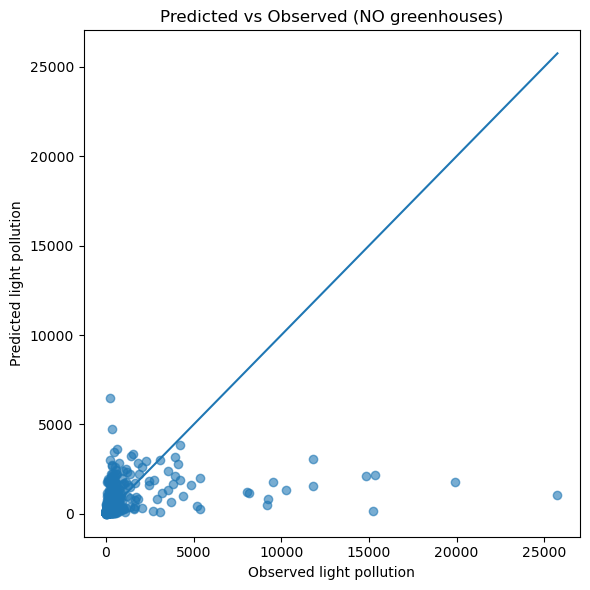


=== Top 15 feature importances (NO greenhouses) ===
           feature  importance
      road_density    0.439137
   building_volume    0.279172
population_density    0.206205
     city_Den Haag    0.039366
    city_Amsterdam    0.036120


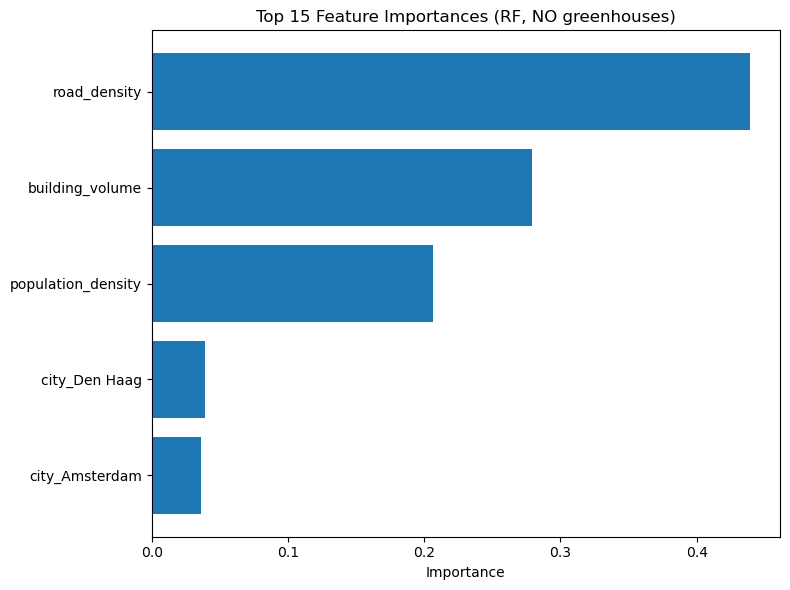


=== City-wise transfer performance (NO greenhouses) ===
               split      R2      MAE      RMSE
Amsterdam → Den Haag -0.0049 404.7033 1795.9235
Den Haag → Amsterdam -6.5232 236.9392  478.7603


In [2]:
#without greenhouses baseline
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt

# -----------------------
# Load data (REMOVE greenhouse columns)
# -----------------------
df = pd.read_csv("light_pollution_data.csv")

# Identify and drop greenhouse-related columns (case-insensitive)
greenhouse_cols = [c for c in df.columns if "greenhouse" in c.lower()]
print("Dropping greenhouse columns:", greenhouse_cols)

df_nog = df.drop(columns=greenhouse_cols)

# Define target and predictors
X = df_nog.drop(columns=["light_pollution", "fid"])
y = df_nog["light_pollution"]

# -----------------------
# Column types
# -----------------------
numeric_features = [
    "building_volume",
    "population_density",
    "road_density",
]

categorical_features = ["city"]

# (Optional) sanity check: columns missing?
missing_num = [c for c in numeric_features if c not in X.columns]
missing_cat = [c for c in categorical_features if c not in X.columns]
if missing_num or missing_cat:
    raise ValueError(f"Missing columns. numeric missing={missing_num}, categorical missing={missing_cat}")

print("Numeric features used:", numeric_features)
print("Categorical features used:", categorical_features)

# -----------------------
# Preprocessing
# -----------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

# -----------------------
# Random Forest model
# -----------------------
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    oob_score=True,
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf)
])

# -----------------------
# Helper: pretty metrics
# -----------------------
def regression_report(y_true, y_pred, label=""):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return pd.DataFrame([{
        "split": label,
        "R2": r2,
        "MAE": mae,
        "RMSE": rmse
    }])

# -----------------------
# A) Normal random split (baseline)
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

report_baseline = regression_report(y_test, y_pred, label="Random split (80/20)")
oob = model.named_steps["model"].oob_score_

print("\n=== Baseline performance (NO greenhouses) ===")
print(report_baseline.to_string(index=False, float_format=lambda v: f"{v:0.4f}"))
print(f"OOB R2 (train, approximate): {oob:0.4f}")

# Plot predicted vs observed (NO log scale)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
mn, mx = float(np.min(y_test)), float(np.max(y_test))
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Observed light pollution")
plt.ylabel("Predicted light pollution")
plt.title("Predicted vs Observed (NO greenhouses)")
plt.tight_layout()
plt.show()

# -----------------------
# Feature importances (from the fitted model)
# -----------------------
pre = model.named_steps["preprocessor"]
cat_encoder = pre.named_transformers_["cat"].named_steps["encoder"]

cat_names = list(cat_encoder.get_feature_names_out(categorical_features))
feature_names = numeric_features + cat_names

importances = model.named_steps["model"].feature_importances_

importance_df = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
      .sort_values(by="importance", ascending=False)
      .reset_index(drop=True)
)

print("\n=== Top 15 feature importances (NO greenhouses) ===")
print(importance_df.head(15).to_string(index=False, float_format=lambda v: f"{v:0.6f}"))

# Optional: plot top 15
topk = importance_df.head(15).iloc[::-1]
plt.figure(figsize=(8,6))
plt.barh(topk["feature"], topk["importance"])
plt.xlabel("Importance")
plt.title("Top 15 Feature Importances (RF, NO greenhouses)")
plt.tight_layout()
plt.show()

# -----------------------
# B) City-to-city generalization
# -----------------------
def train_on_city_test_on_city(train_city, test_city):
    train_df = df_nog[df_nog["city"] == train_city]
    test_df  = df_nog[df_nog["city"] == test_city]

    X_tr = train_df.drop(columns=["light_pollution", "fid"])
    y_tr = train_df["light_pollution"]

    X_te = test_df.drop(columns=["light_pollution", "fid"])
    y_te = test_df["light_pollution"]

    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)
    return regression_report(y_te, pred, label=f"{train_city} → {test_city}")

report_city_1 = train_on_city_test_on_city("Amsterdam", "Den Haag")
report_city_2 = train_on_city_test_on_city("Den Haag", "Amsterdam")

report_citywise = pd.concat([report_city_1, report_city_2], ignore_index=True)

print("\n=== City-wise transfer performance (NO greenhouses) ===")
print(report_citywise.to_string(index=False, float_format=lambda v: f"{v:0.4f}"))


Dropping greenhouse columns: ['greenhouse_coverage']

=== Amsterdam only (regular target, NO greenhouses) ===
Metric    Value
    R²   0.3209
   MAE  69.4339
  RMSE 129.2711
OOB R²   0.3425


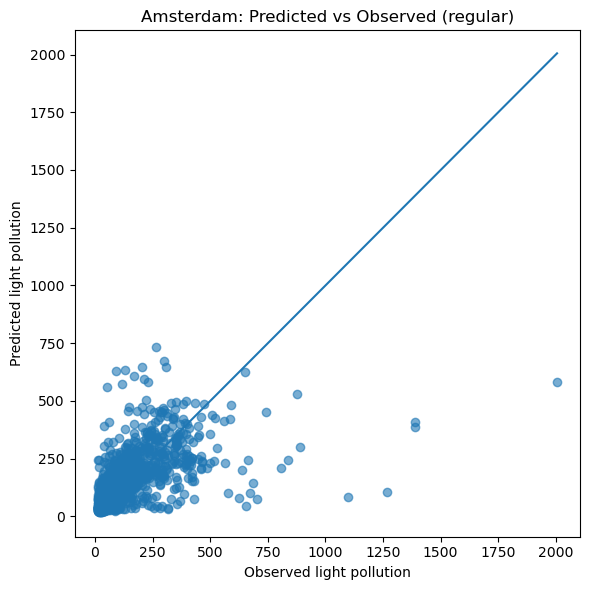


Top features:
           feature  importance
   building_volume    0.619297
population_density    0.194227
      road_density    0.186476


In [3]:
# Amsterdam No greenhouses baseline (NO spatial grouping)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# -----------------------
# Load + filter city
# -----------------------
df = pd.read_csv("light_pollution_data.csv")
df = df[df["city"] == "Amsterdam"].copy()

# Drop greenhouse columns
greenhouse_cols = [c for c in df.columns if "greenhouse" in c.lower()]
print("Dropping greenhouse columns:", greenhouse_cols)
df = df.drop(columns=greenhouse_cols)

# Define X/y
X = df.drop(columns=["light_pollution", "fid"])
y = df["light_pollution"]

# Features (city is constant so we don't use it)
numeric_features = ["building_volume", "population_density", "road_density"]

# -----------------------
# Preprocessing
# -----------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric_features),
    ],
    remainder="drop"
)

# -----------------------
# Model
# -----------------------
rf = RandomForestRegressor(
    n_estimators=300,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    oob_score=True
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf)
])

# -----------------------
# Train/test split (standard random split)
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit / predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# -----------------------
# Metrics
# -----------------------
results = pd.DataFrame({
    "Metric": ["R²", "MAE", "RMSE", "OOB R²"],
    "Value": [
        r2_score(y_test, y_pred),
        mean_absolute_error(y_test, y_pred),
        np.sqrt(mean_squared_error(y_test, y_pred)),
        model.named_steps["model"].oob_score_
    ]
})

print("\n=== Amsterdam only (regular target, NO greenhouses) ===")
print(results.to_string(index=False, float_format=lambda v: f"{v:.4f}"))

# -----------------------
# Plot: Predicted vs Observed
# -----------------------
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Observed light pollution")
plt.ylabel("Predicted light pollution")
plt.title("Amsterdam: Predicted vs Observed (regular)")
plt.tight_layout()
plt.show()

# -----------------------
# Feature importance
# -----------------------
importances = model.named_steps["model"].feature_importances_
importance_df = (
    pd.DataFrame({"feature": numeric_features, "importance": importances})
      .sort_values("importance", ascending=False)
)

print("\nTop features:")
print(importance_df.to_string(index=False, float_format=lambda v: f"{v:.6f}"))


Dropping greenhouse columns: ['greenhouse_coverage']

=== Den Haag only (regular target) ===
Metric     Value
    R²    0.0732
   MAE  671.7740
  RMSE 2268.9968
OOB R²    0.0605


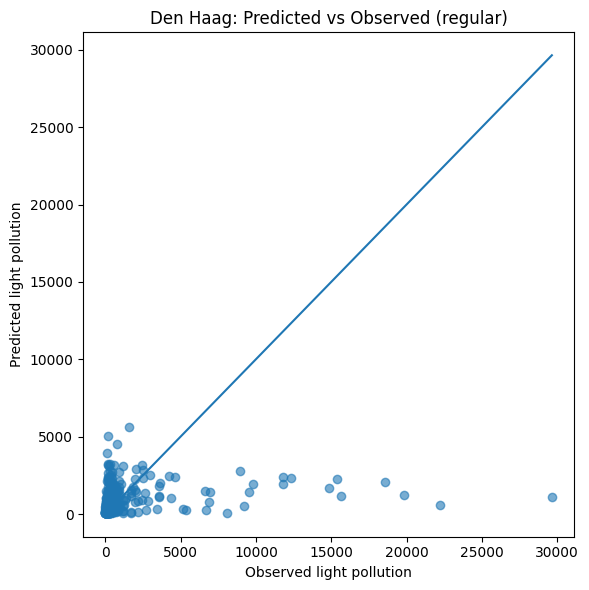


Top features:
           feature  importance
      road_density    0.476224
   building_volume    0.300805
population_density    0.222971


In [26]:
#the hague no greenhouse baseline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# -----------------------
# Load + filter city
# -----------------------
df = pd.read_csv("light_pollution_data.csv")
df = df[df["city"] == "Den Haag"].copy()

# Drop greenhouse columns
greenhouse_cols = [c for c in df.columns if "greenhouse" in c.lower()]
print("Dropping greenhouse columns:", greenhouse_cols)
df = df.drop(columns=greenhouse_cols)

X = df.drop(columns=["light_pollution", "fid"])
y = df["light_pollution"]

numeric_features = ["building_volume", "population_density", "road_density"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric_features),
    ],
    remainder="drop"
)

rf = RandomForestRegressor(
    n_estimators=300,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    oob_score=True
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

results = pd.DataFrame({
    "Metric": ["R²", "MAE", "RMSE", "OOB R²"],
    "Value": [
        r2_score(y_test, y_pred),
        mean_absolute_error(y_test, y_pred),
        np.sqrt(mean_squared_error(y_test, y_pred)),
        model.named_steps["model"].oob_score_
    ]
})

print("\n=== Den Haag only (regular target) ===")
print(results.to_string(index=False, float_format=lambda v: f"{v:.4f}"))

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Observed light pollution")
plt.ylabel("Predicted light pollution")
plt.title("Den Haag: Predicted vs Observed (regular)")
plt.tight_layout()
plt.show()

importances = model.named_steps["model"].feature_importances_
importance_df = (pd.DataFrame({"feature": numeric_features, "importance": importances})
                 .sort_values("importance", ascending=False))
print("\nTop features:")
print(importance_df.to_string(index=False, float_format=lambda v: f"{v:.6f}"))


Dropping greenhouse columns: ['greenhouse_coverage']

=== Amsterdam only (log1p target) ===
Metric    Value
    R²   0.3539
   MAE  60.2900
  RMSE 126.0897
OOB R²   0.6106


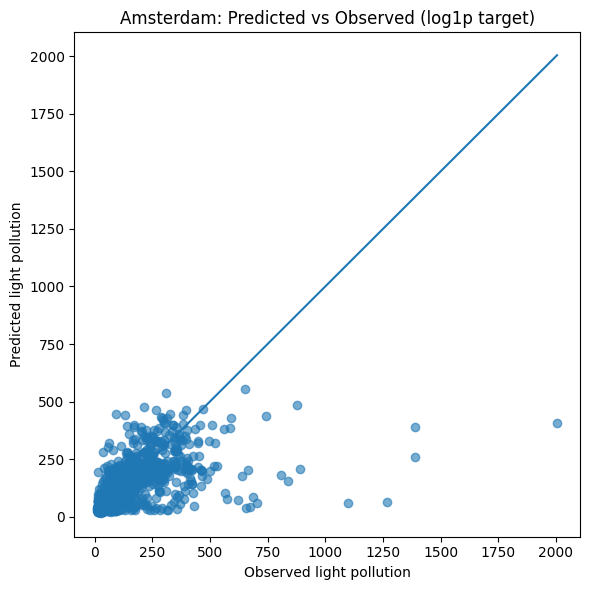

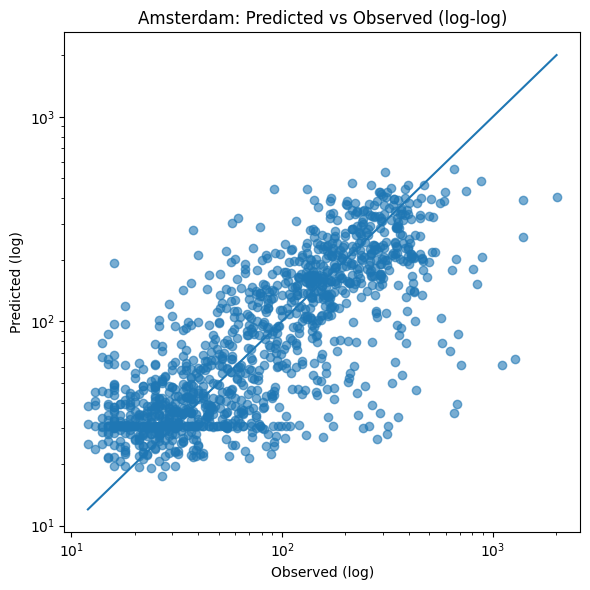


Top features:
           feature  importance
   building_volume    0.698363
      road_density    0.199443
population_density    0.102194


In [20]:
#Amsterdam only — log1p target (NO greenhouses)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

df = pd.read_csv("light_pollution_data.csv")
df = df[df["city"] == "Amsterdam"].copy()

greenhouse_cols = [c for c in df.columns if "greenhouse" in c.lower()]
print("Dropping greenhouse columns:", greenhouse_cols)
df = df.drop(columns=greenhouse_cols)

X = df.drop(columns=["light_pollution", "fid"])
y = df["light_pollution"]

numeric_features = ["building_volume", "population_density", "road_density"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric_features),
    ],
    remainder="drop"
)

rf = RandomForestRegressor(
    n_estimators=300,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    oob_score=True
)

base_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf)
])

log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=False)

model = TransformedTargetRegressor(
    regressor=base_pipeline,
    transformer=log_transformer
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

results = pd.DataFrame({
    "Metric": ["R²", "MAE", "RMSE", "OOB R²"],
    "Value": [
        r2_score(y_test, y_pred),
        mean_absolute_error(y_test, y_pred),
        np.sqrt(mean_squared_error(y_test, y_pred)),
        model.regressor_.named_steps["model"].oob_score_
    ]
})

print("\n=== Amsterdam only (log1p target) ===")
print(results.to_string(index=False, float_format=lambda v: f"{v:.4f}"))

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Observed light pollution")
plt.ylabel("Predicted light pollution")
plt.title("Amsterdam: Predicted vs Observed (log1p target)")
plt.tight_layout()
plt.show()

# Optional log-log diagnostic
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xscale("log"); plt.yscale("log")
mn = max(y_test[y_test > 0].min(), 1e-6)
mx = y_test.max()
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Observed (log)"); plt.ylabel("Predicted (log)")
plt.title("Amsterdam: Predicted vs Observed (log-log)")
plt.tight_layout()
plt.show()

importances = model.regressor_.named_steps["model"].feature_importances_
importance_df = (pd.DataFrame({"feature": numeric_features, "importance": importances})
                 .sort_values("importance", ascending=False))
print("\nTop features:")
print(importance_df.to_string(index=False, float_format=lambda v: f"{v:.6f}"))


Dropping greenhouse columns: ['greenhouse_coverage']

=== Den Haag only (log1p target) ===
Metric     Value
    R²    0.0241
   MAE  563.6488
  RMSE 2328.2524
OOB R²    0.4345


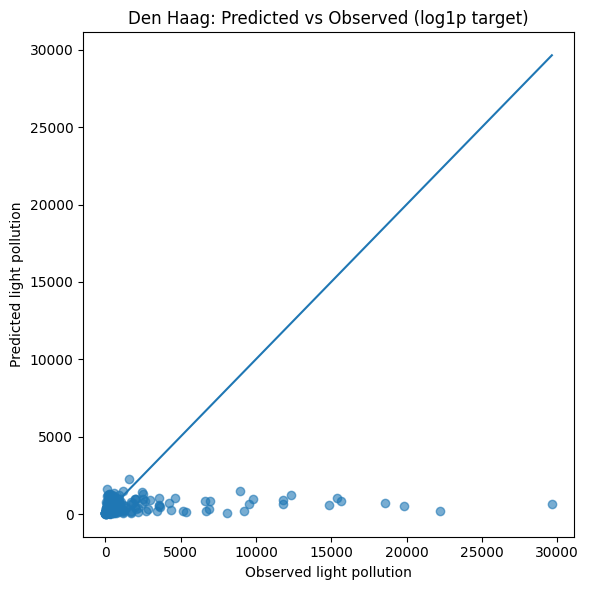

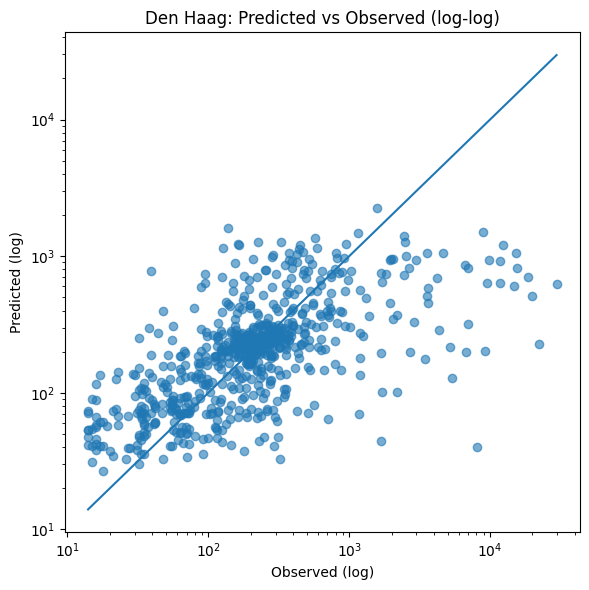


Top features:
           feature  importance
   building_volume    0.589688
      road_density    0.282954
population_density    0.127358


In [27]:
#Den Haag only — log1p target (NO greenhouses)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

df = pd.read_csv("light_pollution_data.csv")
df = df[df["city"] == "Den Haag"].copy()

greenhouse_cols = [c for c in df.columns if "greenhouse" in c.lower()]
print("Dropping greenhouse columns:", greenhouse_cols)
df = df.drop(columns=greenhouse_cols)

X = df.drop(columns=["light_pollution", "fid"])
y = df["light_pollution"]

numeric_features = ["building_volume", "population_density", "road_density"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric_features),
    ],
    remainder="drop"
)

rf = RandomForestRegressor(
    n_estimators=300,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    oob_score=True
)

base_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf)
])

log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=False)

model = TransformedTargetRegressor(
    regressor=base_pipeline,
    transformer=log_transformer
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

results = pd.DataFrame({
    "Metric": ["R²", "MAE", "RMSE", "OOB R²"],
    "Value": [
        r2_score(y_test, y_pred),
        mean_absolute_error(y_test, y_pred),
        np.sqrt(mean_squared_error(y_test, y_pred)),
        model.regressor_.named_steps["model"].oob_score_
    ]
})

print("\n=== Den Haag only (log1p target) ===")
print(results.to_string(index=False, float_format=lambda v: f"{v:.4f}"))

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Observed light pollution")
plt.ylabel("Predicted light pollution")
plt.title("Den Haag: Predicted vs Observed (log1p target)")
plt.tight_layout()
plt.show()

# Optional log-log diagnostic
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xscale("log"); plt.yscale("log")
mn = max(y_test[y_test > 0].min(), 1e-6)
mx = y_test.max()
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Observed (log)"); plt.ylabel("Predicted (log)")
plt.title("Den Haag: Predicted vs Observed (log-log)")
plt.tight_layout()
plt.show()

importances = model.regressor_.named_steps["model"].feature_importances_
importance_df = (pd.DataFrame({"feature": numeric_features, "importance": importances})
                 .sort_values("importance", ascending=False))
print("\nTop features:")
print(importance_df.to_string(index=False, float_format=lambda v: f"{v:.6f}"))



=== Den Haag only (regular target, WITH greenhouses) ===
Numeric features used: ['building_volume', 'population_density', 'road_density', 'greenhouse_coverage']
Metric     Value
    R²    0.3102
   MAE  557.8117
  RMSE 1957.4170
OOB R²    0.2507


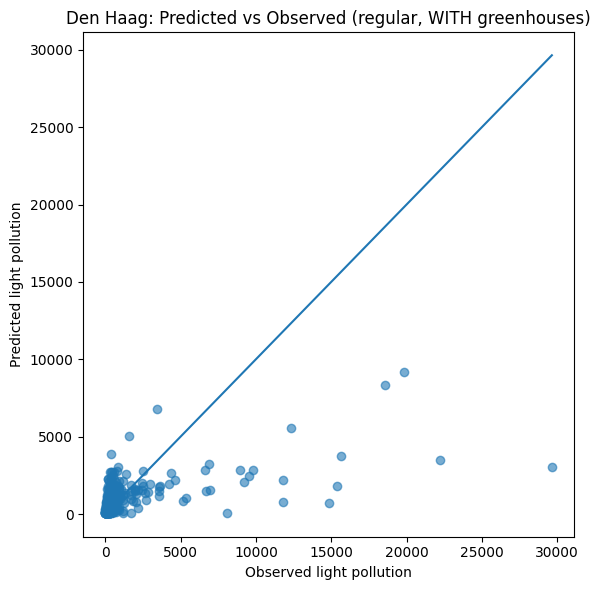


Top features:
            feature  importance
greenhouse_coverage    0.595256
 population_density    0.157943
       road_density    0.156565
    building_volume    0.090235


In [22]:
# 2) Den Haag only — regular target (WITH greenhouses)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

df = pd.read_csv("light_pollution_data.csv")
df = df[df["city"] == "Den Haag"].copy()

X = df.drop(columns=["light_pollution", "fid"])
y = df["light_pollution"]

numeric_features = ["building_volume", "population_density", "road_density"]
greenhouse_cols = [c for c in X.columns if "greenhouse" in c.lower()]
numeric_features = list(dict.fromkeys(numeric_features + greenhouse_cols))

missing_num = [c for c in numeric_features if c not in X.columns]
if missing_num:
    raise ValueError(f"Missing numeric columns: {missing_num}")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric_features),
    ],
    remainder="drop"
)

rf = RandomForestRegressor(
    n_estimators=300,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    oob_score=True
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

results = pd.DataFrame({
    "Metric": ["R²", "MAE", "RMSE", "OOB R²"],
    "Value": [
        r2_score(y_test, y_pred),
        mean_absolute_error(y_test, y_pred),
        np.sqrt(mean_squared_error(y_test, y_pred)),
        model.named_steps["model"].oob_score_
    ]
})

print("\n=== Den Haag only (regular target, WITH greenhouses) ===")
print("Numeric features used:", numeric_features)
print(results.to_string(index=False, float_format=lambda v: f"{v:.4f}"))

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Observed light pollution")
plt.ylabel("Predicted light pollution")
plt.title("Den Haag: Predicted vs Observed (regular, WITH greenhouses)")
plt.tight_layout()
plt.show()

importances = model.named_steps["model"].feature_importances_
importance_df = (pd.DataFrame({"feature": numeric_features, "importance": importances})
                 .sort_values("importance", ascending=False))
print("\nTop features:")
print(importance_df.to_string(index=False, float_format=lambda v: f"{v:.6f}"))



=== Amsterdam only (regular target, WITH greenhouses) ===
Numeric features used: ['building_volume', 'population_density', 'road_density', 'greenhouse_coverage']
Metric    Value
    R²   0.3493
   MAE  68.5682
  RMSE 126.5344
OOB R²   0.3519


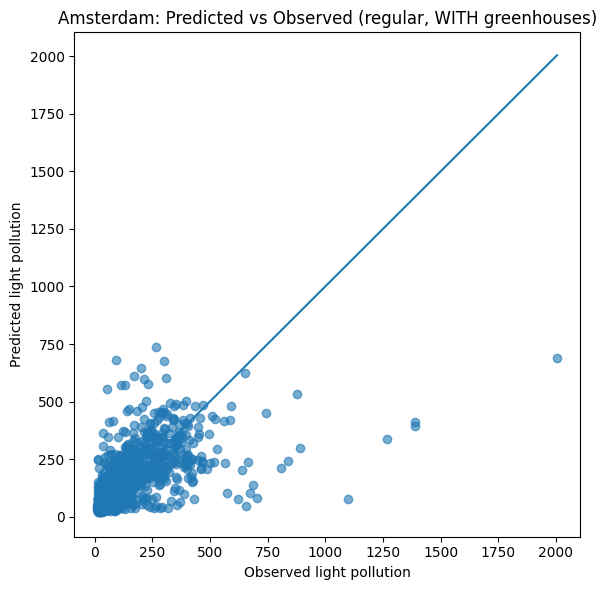


Top features:
            feature  importance
    building_volume    0.612519
 population_density    0.186092
       road_density    0.177971
greenhouse_coverage    0.023417


In [23]:
# 1) Amsterdam only — regular target (WITH greenhouses)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

df = pd.read_csv("light_pollution_data.csv")
df = df[df["city"] == "Amsterdam"].copy()

X = df.drop(columns=["light_pollution", "fid"])
y = df["light_pollution"]

# Base numeric features + auto-add greenhouse columns
numeric_features = ["building_volume", "population_density", "road_density"]
greenhouse_cols = [c for c in X.columns if "greenhouse" in c.lower()]
numeric_features = list(dict.fromkeys(numeric_features + greenhouse_cols))

missing_num = [c for c in numeric_features if c not in X.columns]
if missing_num:
    raise ValueError(f"Missing numeric columns: {missing_num}")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric_features),
    ],
    remainder="drop"
)

rf = RandomForestRegressor(
    n_estimators=300,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    oob_score=True
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

results = pd.DataFrame({
    "Metric": ["R²", "MAE", "RMSE", "OOB R²"],
    "Value": [
        r2_score(y_test, y_pred),
        mean_absolute_error(y_test, y_pred),
        np.sqrt(mean_squared_error(y_test, y_pred)),
        model.named_steps["model"].oob_score_
    ]
})

print("\n=== Amsterdam only (regular target, WITH greenhouses) ===")
print("Numeric features used:", numeric_features)
print(results.to_string(index=False, float_format=lambda v: f"{v:.4f}"))

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Observed light pollution")
plt.ylabel("Predicted light pollution")
plt.title("Amsterdam: Predicted vs Observed (regular, WITH greenhouses)")
plt.tight_layout()
plt.show()

importances = model.named_steps["model"].feature_importances_
importance_df = (pd.DataFrame({"feature": numeric_features, "importance": importances})
                 .sort_values("importance", ascending=False))
print("\nTop features:")
print(importance_df.to_string(index=False, float_format=lambda v: f"{v:.6f}"))



=== Amsterdam only (log1p target, WITH greenhouses) ===
Numeric features used: ['building_volume', 'population_density', 'road_density', 'greenhouse_coverage']
Metric    Value
    R²   0.3556
   MAE  60.2567
  RMSE 125.9292
OOB R²   0.6108


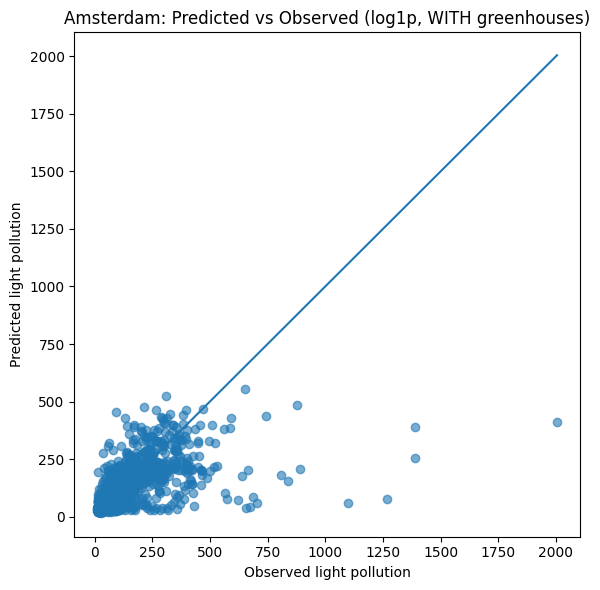

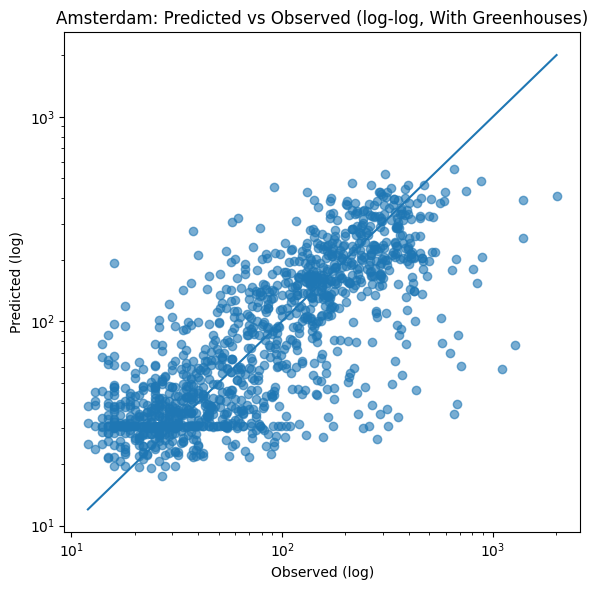


Top features:
            feature  importance
    building_volume    0.697842
       road_density    0.198510
 population_density    0.102183
greenhouse_coverage    0.001465


In [30]:
# 3) Amsterdam only — log1p target (WITH greenhouses)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

df = pd.read_csv("light_pollution_data.csv")
df = df[df["city"] == "Amsterdam"].copy()

X = df.drop(columns=["light_pollution", "fid"])
y = df["light_pollution"]

numeric_features = ["building_volume", "population_density", "road_density"]
greenhouse_cols = [c for c in X.columns if "greenhouse" in c.lower()]
numeric_features = list(dict.fromkeys(numeric_features + greenhouse_cols))

missing_num = [c for c in numeric_features if c not in X.columns]
if missing_num:
    raise ValueError(f"Missing numeric columns: {missing_num}")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric_features),
    ],
    remainder="drop"
)

rf = RandomForestRegressor(
    n_estimators=300,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    oob_score=True
)

base_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf)
])

log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=False)

model = TransformedTargetRegressor(
    regressor=base_pipeline,
    transformer=log_transformer
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

results = pd.DataFrame({
    "Metric": ["R²", "MAE", "RMSE", "OOB R²"],
    "Value": [
        r2_score(y_test, y_pred),
        mean_absolute_error(y_test, y_pred),
        np.sqrt(mean_squared_error(y_test, y_pred)),
        model.regressor_.named_steps["model"].oob_score_
    ]
})

print("\n=== Amsterdam only (log1p target, WITH greenhouses) ===")
print("Numeric features used:", numeric_features)
print(results.to_string(index=False, float_format=lambda v: f"{v:.4f}"))

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Observed light pollution")
plt.ylabel("Predicted light pollution")
plt.title("Amsterdam: Predicted vs Observed (log1p, WITH greenhouses)")
plt.tight_layout()
plt.show()

# Optional log-log diagnostic
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xscale("log"); plt.yscale("log")
mn = max(y_test[y_test > 0].min(), 1e-6)
mx = y_test.max()
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Observed (log)"); plt.ylabel("Predicted (log)")
plt.title("Amsterdam: Predicted vs Observed (log-log, With Greenhouses)")
plt.tight_layout()
plt.show()

importances = model.regressor_.named_steps["model"].feature_importances_
importance_df = (pd.DataFrame({"feature": numeric_features, "importance": importances})
                 .sort_values("importance", ascending=False))
print("\nTop features:")
print(importance_df.to_string(index=False, float_format=lambda v: f"{v:.6f}"))



=== Den Haag only (log1p target, WITH greenhouses) ===
Numeric features used: ['building_volume', 'population_density', 'road_density', 'greenhouse_coverage']
Metric     Value
    R²    0.1450
   MAE  513.0010
  RMSE 2179.3021
OOB R²    0.5377


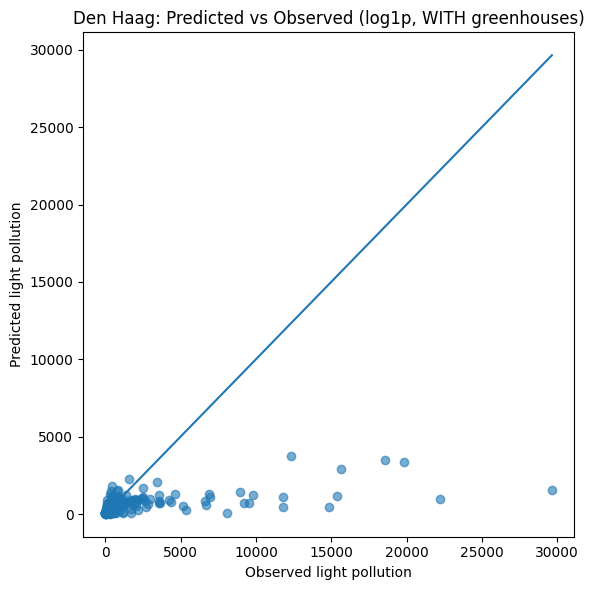

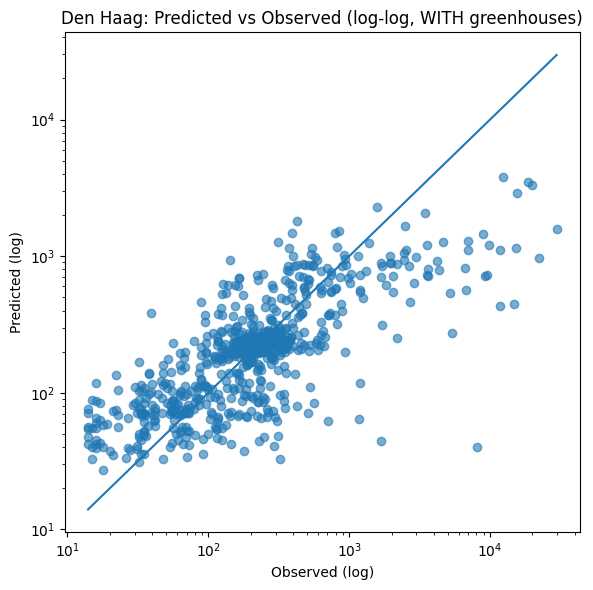


Top features:
            feature  importance
greenhouse_coverage    0.401656
    building_volume    0.377451
       road_density    0.127990
 population_density    0.092904


In [29]:
# 4) Den Haag only — log1p target (WITH greenhouses)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

df = pd.read_csv("light_pollution_data.csv")
df = df[df["city"] == "Den Haag"].copy()

X = df.drop(columns=["light_pollution", "fid"])
y = df["light_pollution"]

numeric_features = ["building_volume", "population_density", "road_density"]
greenhouse_cols = [c for c in X.columns if "greenhouse" in c.lower()]
numeric_features = list(dict.fromkeys(numeric_features + greenhouse_cols))

missing_num = [c for c in numeric_features if c not in X.columns]
if missing_num:
    raise ValueError(f"Missing numeric columns: {missing_num}")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric_features),
    ],
    remainder="drop"
)

rf = RandomForestRegressor(
    n_estimators=300,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    oob_score=True
)

base_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf)
])

log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=False)

model = TransformedTargetRegressor(
    regressor=base_pipeline,
    transformer=log_transformer
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

results = pd.DataFrame({
    "Metric": ["R²", "MAE", "RMSE", "OOB R²"],
    "Value": [
        r2_score(y_test, y_pred),
        mean_absolute_error(y_test, y_pred),
        np.sqrt(mean_squared_error(y_test, y_pred)),
        model.regressor_.named_steps["model"].oob_score_
    ]
})

print("\n=== Den Haag only (log1p target, WITH greenhouses) ===")
print("Numeric features used:", numeric_features)
print(results.to_string(index=False, float_format=lambda v: f"{v:.4f}"))

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Observed light pollution")
plt.ylabel("Predicted light pollution")
plt.title("Den Haag: Predicted vs Observed (log1p, WITH greenhouses)")
plt.tight_layout()
plt.show()

# Optional log-log diagnostic
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xscale("log"); plt.yscale("log")
mn = max(y_test[y_test > 0].min(), 1e-6)
mx = y_test.max()
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Observed (log)"); plt.ylabel("Predicted (log)")
plt.title("Den Haag: Predicted vs Observed (log-log, WITH greenhouses)")
plt.tight_layout()
plt.show()

importances = model.regressor_.named_steps["model"].feature_importances_
importance_df = (pd.DataFrame({"feature": numeric_features, "importance": importances})
                 .sort_values("importance", ascending=False))
print("\nTop features:")
print(importance_df.to_string(index=False, float_format=lambda v: f"{v:.6f}"))


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _get_rf_from_model(model):
    """
    Returns (pipeline, rf) from either:
    - Pipeline(preprocessor -> model)
    - TransformedTargetRegressor(regressor=Pipeline(...))
    """
    if hasattr(model, "regressor_"):  # TransformedTargetRegressor after fit
        pipe = model.regressor_
    else:
        pipe = model

    rf = pipe.named_steps["model"]
    return pipe, rf


def get_importance_df(model, numeric_features, categorical_features):
    """
    Returns a dataframe with feature names and RF importances.
    Handles:
    - numeric-only (no one-hot)
    - numeric + one-hot categorical features (city)
    - TransformedTargetRegressor wrapping
    """
    pipe, rf = _get_rf_from_model(model)

    # If no categorical features were used, importances map to numeric_features directly
    if (categorical_features is None) or (len(categorical_features) == 0):
        feature_names = list(numeric_features)
    else:
        pre = pipe.named_steps["preprocessor"]
        cat_encoder = pre.named_transformers_["cat"].named_steps["encoder"]
        cat_names = list(cat_encoder.get_feature_names_out(categorical_features))
        feature_names = list(numeric_features) + cat_names

    importances = rf.feature_importances_

    imp_df = (pd.DataFrame({"feature": feature_names, "importance": importances})
              .sort_values("importance", ascending=False)
              .reset_index(drop=True))
    return imp_df


def plot_feature_importances(importance_df, top_n=20, title="Feature importances"):
    """
    Horizontal bar plot of top N importances.
    """
    top = importance_df.head(top_n).iloc[::-1]  # reverse for nice top-to-bottom
    plt.figure(figsize=(9, max(4, 0.35 * len(top))))
    plt.barh(top["feature"], top["importance"])
    plt.xlabel("Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_feature_distributions(df_features, features, title="Feature value distributions", bins=40):
    """
    Histograms for feature values (one plot per feature) using matplotlib only.
    df_features should be a dataframe containing those columns.
    """
    feats = [f for f in features if f in df_features.columns]
    n = len(feats)
    if n == 0:
        print("No features found to plot.")
        return

    # grid layout
    ncols = 3
    nrows = int(np.ceil(n / ncols))

    plt.figure(figsize=(5 * ncols, 3.5 * nrows))
    for i, f in enumerate(feats, start=1):
        ax = plt.subplot(nrows, ncols, i)
        x = df_features[f].dropna().values
        ax.hist(x, bins=bins)
        ax.set_title(f)
        ax.set_xlabel("value")
        ax.set_ylabel("count")
    plt.suptitle(title, y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()



Amsterdam | NO greenhouses | regular target
Metric    Value
    R²   0.3209
   MAE  69.4339
  RMSE 129.2711
OOB R²   0.3425


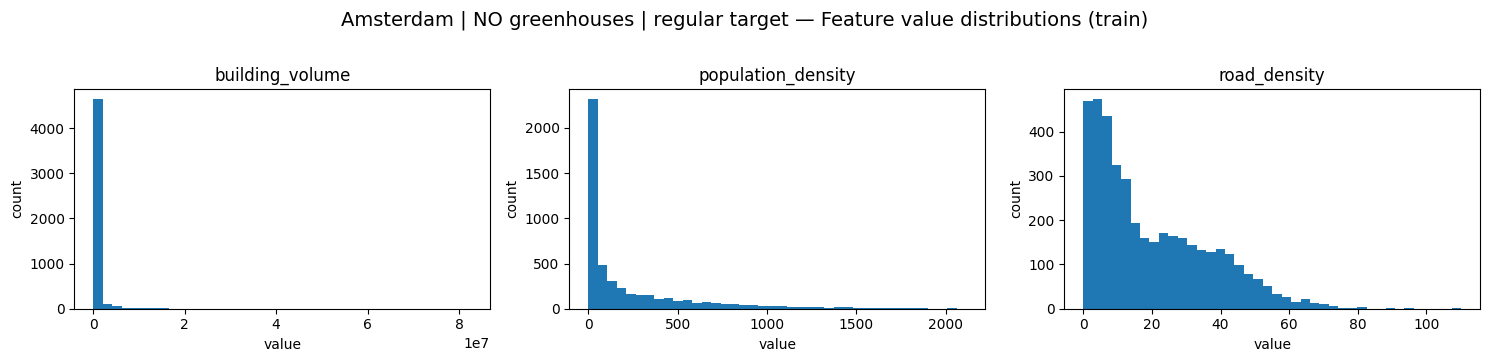

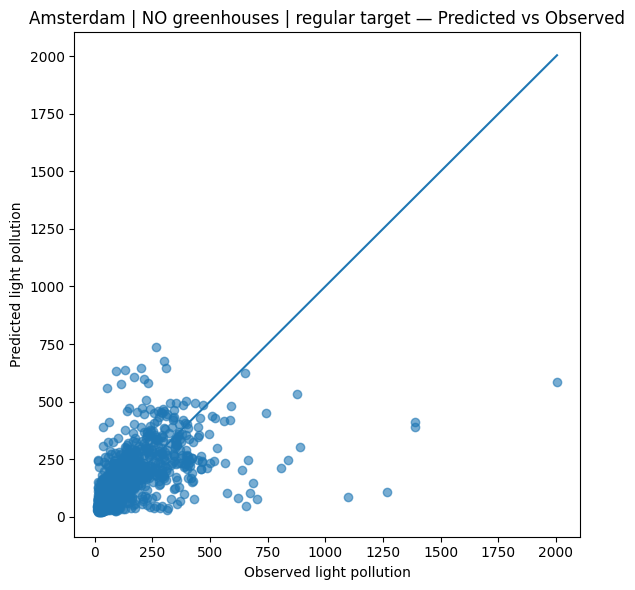

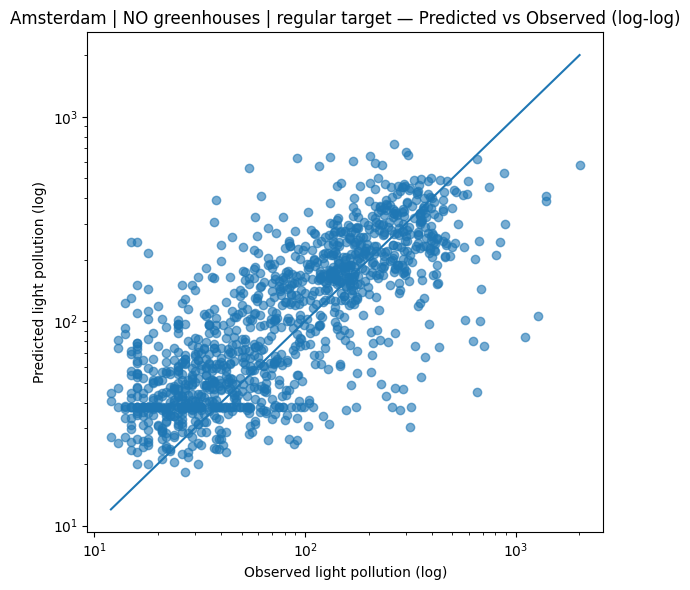

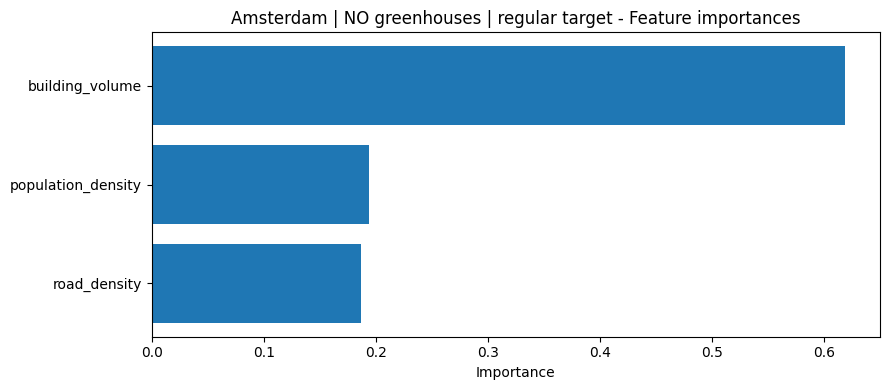


Top 15 importances:
           feature  importance
   building_volume    0.619297
population_density    0.194227
      road_density    0.186476

Amsterdam | NO greenhouses | log target
Metric    Value
    R²   0.3539
   MAE  60.2900
  RMSE 126.0897
OOB R²   0.6106


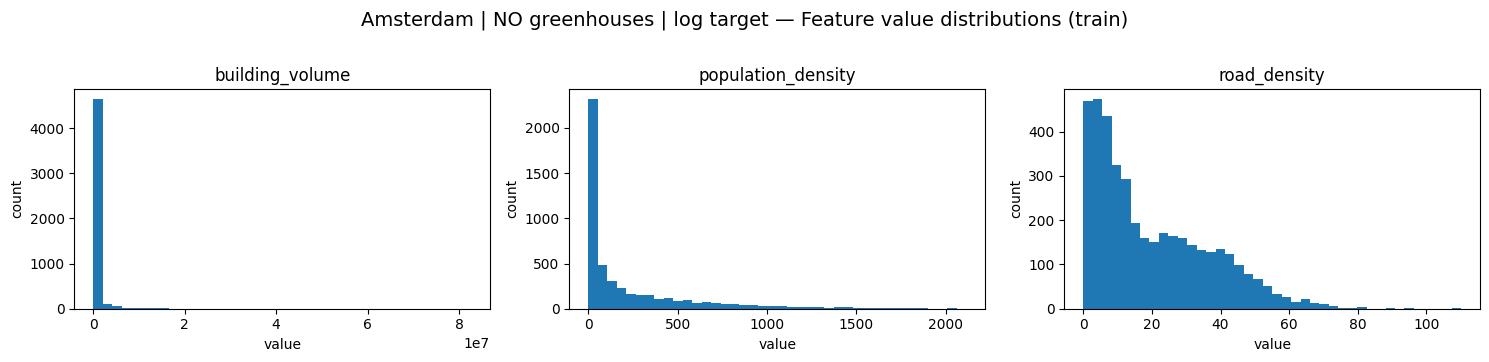

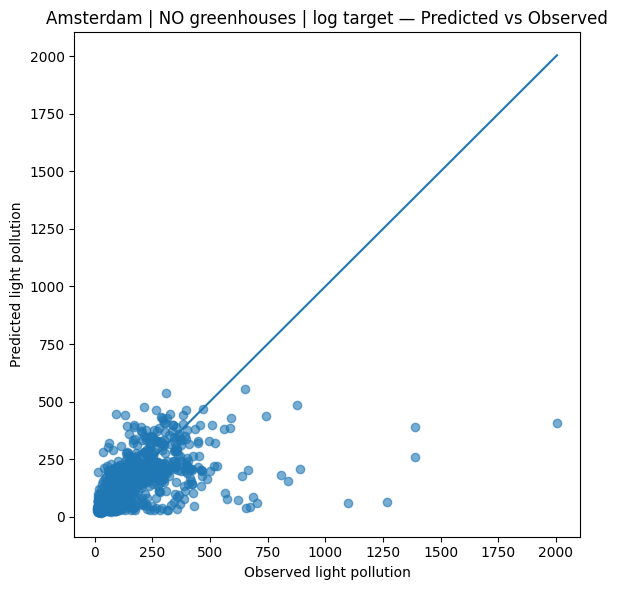

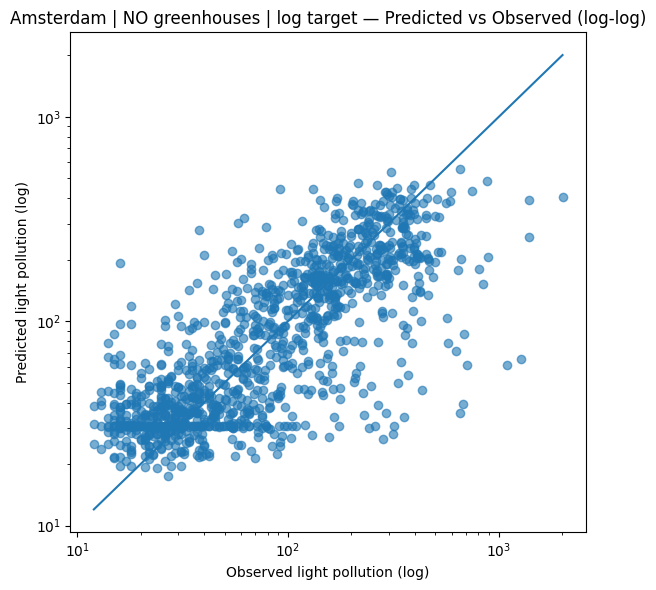

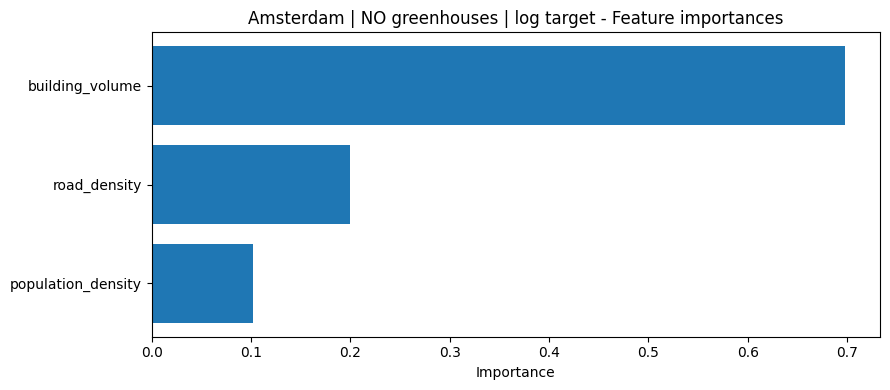


Top 15 importances:
           feature  importance
   building_volume    0.698363
      road_density    0.199443
population_density    0.102194

Amsterdam | WITH greenhouses | regular target
Metric    Value
    R²   0.3493
   MAE  68.5682
  RMSE 126.5344
OOB R²   0.3519


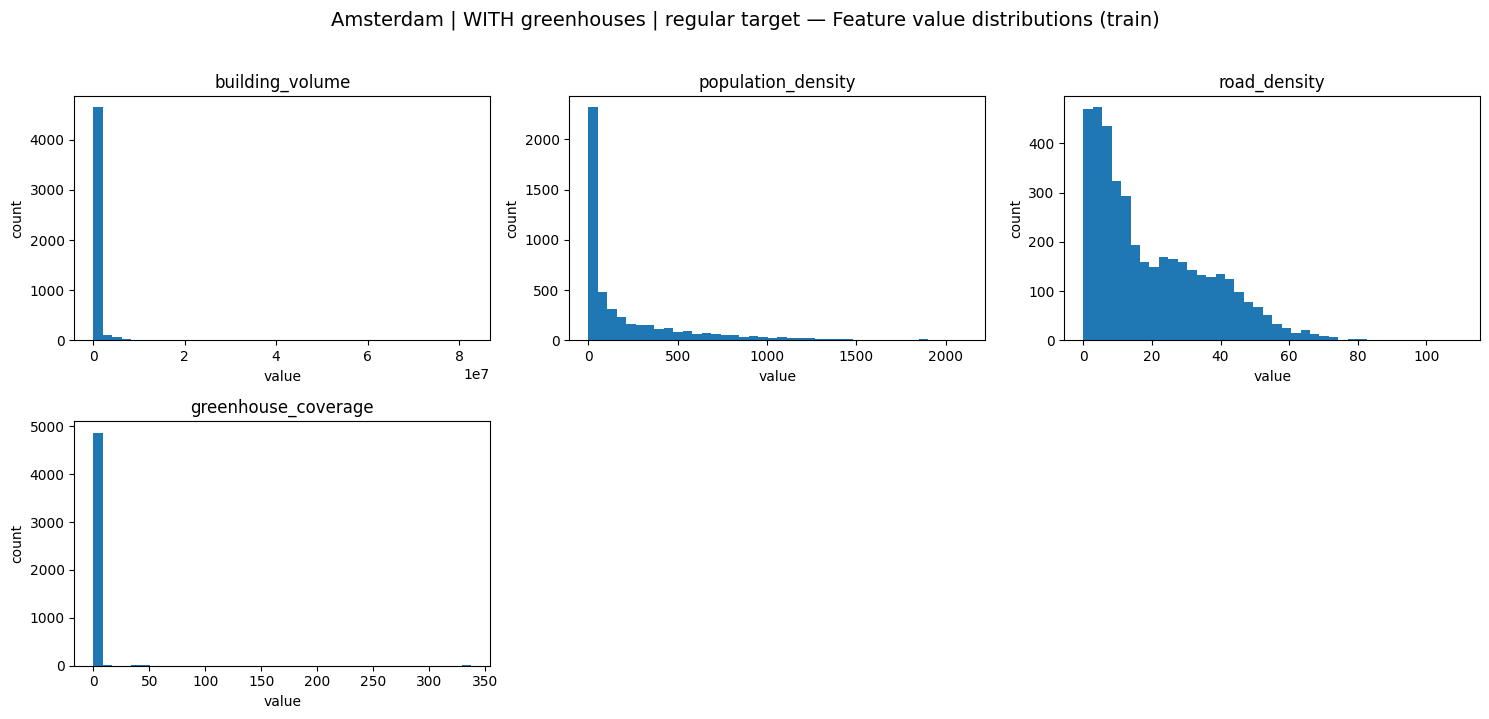

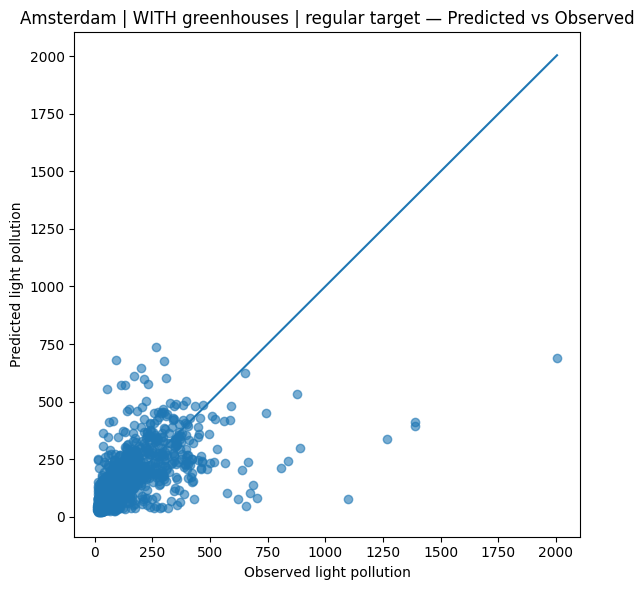

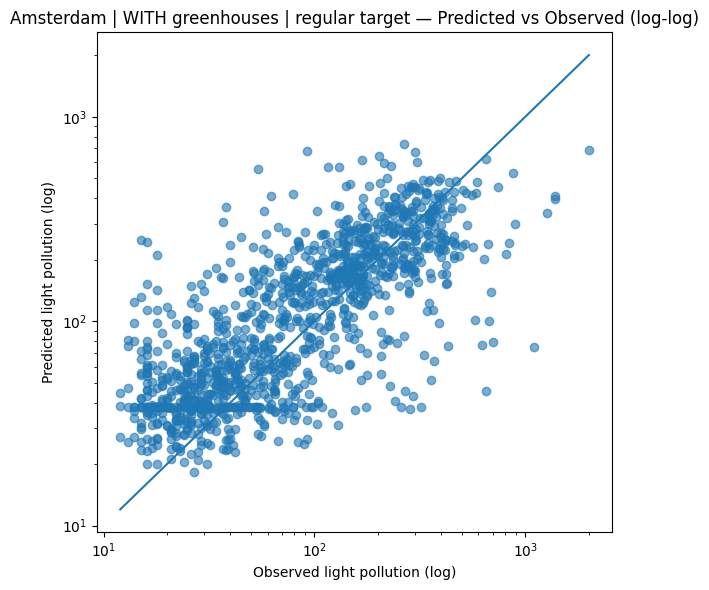

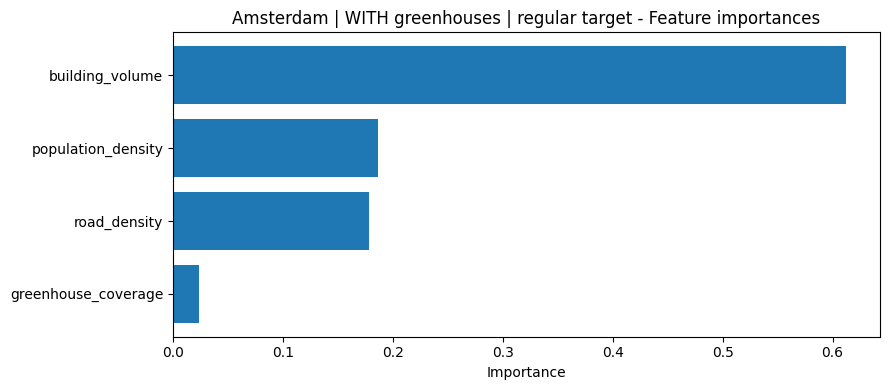


Top 15 importances:
            feature  importance
    building_volume    0.612519
 population_density    0.186092
       road_density    0.177971
greenhouse_coverage    0.023417

Amsterdam | WITH greenhouses | log target
Metric    Value
    R²   0.3556
   MAE  60.2567
  RMSE 125.9292
OOB R²   0.6108


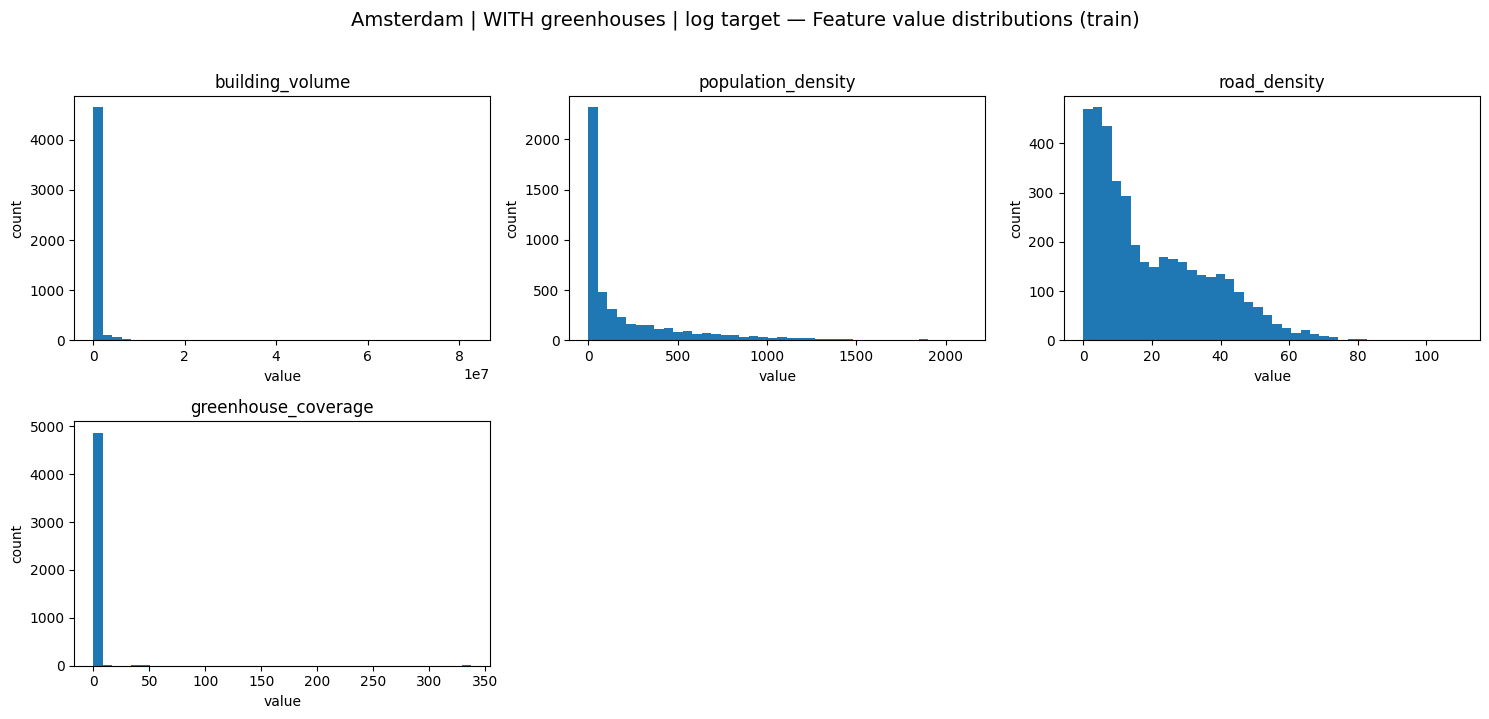

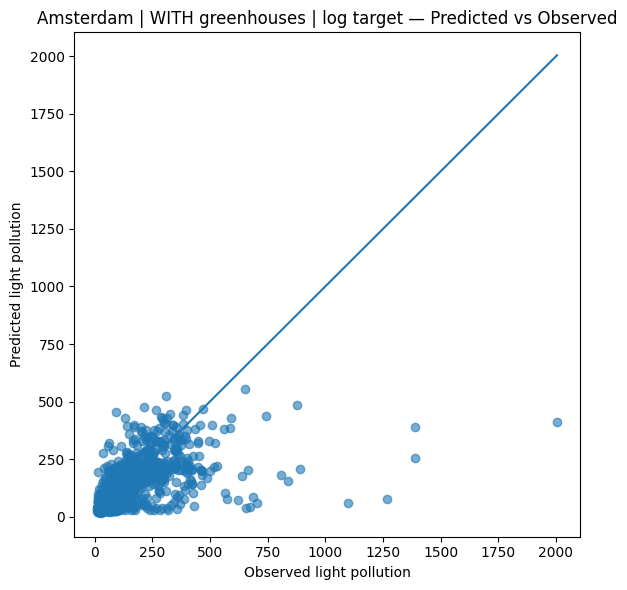

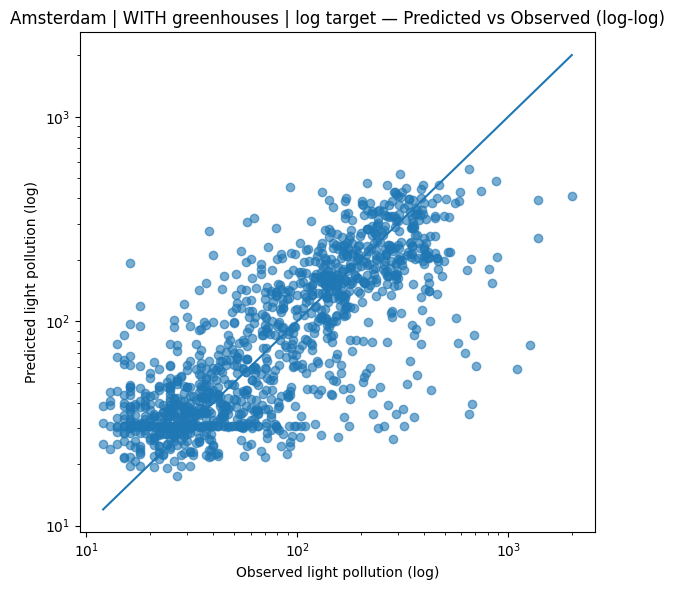

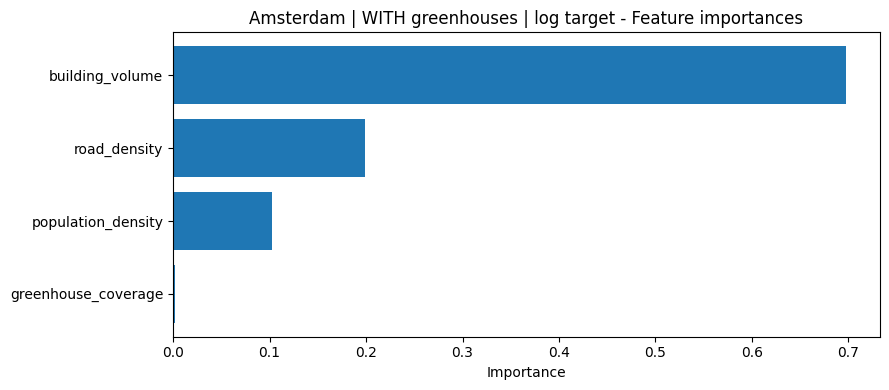


Top 15 importances:
            feature  importance
    building_volume    0.697842
       road_density    0.198510
 population_density    0.102183
greenhouse_coverage    0.001465

Den Haag | NO greenhouses | regular target
Metric     Value
    R²    0.0732
   MAE  671.7740
  RMSE 2268.9968
OOB R²    0.0605


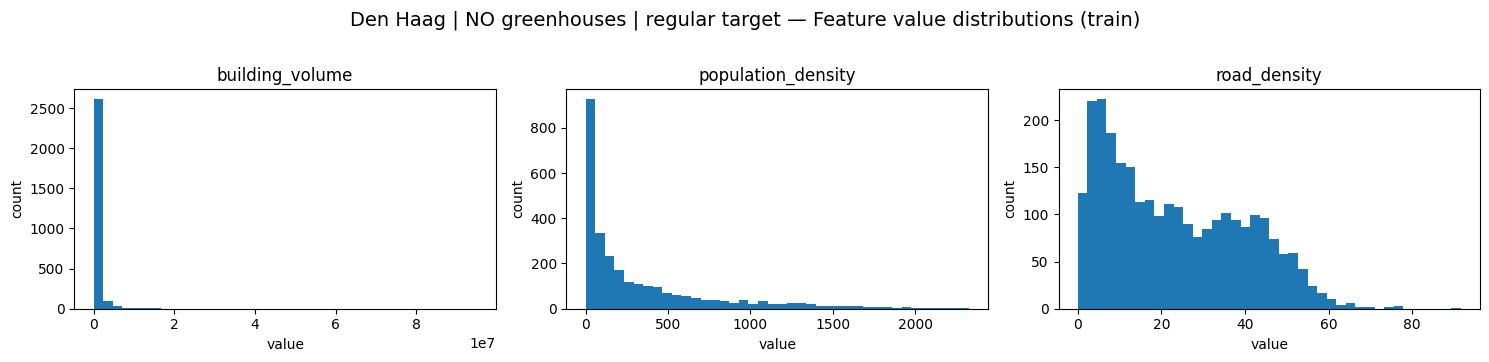

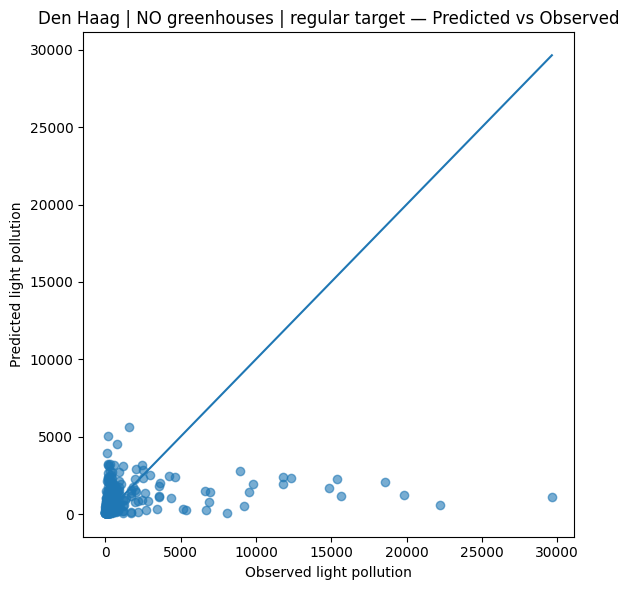

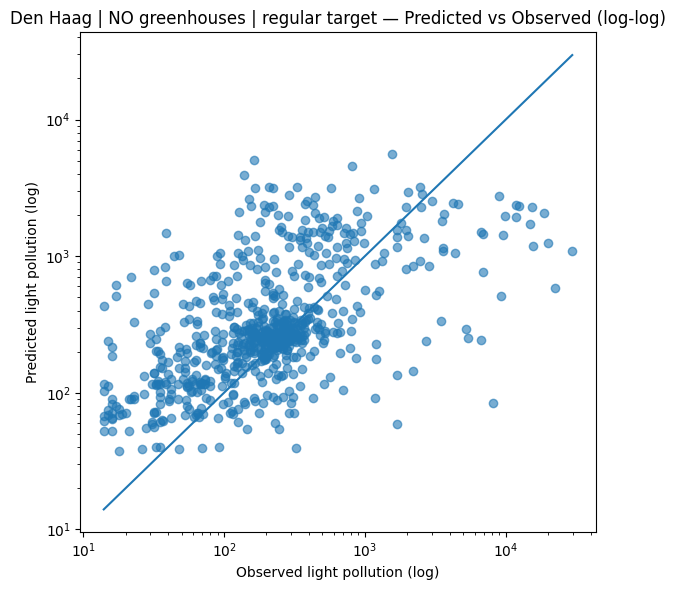

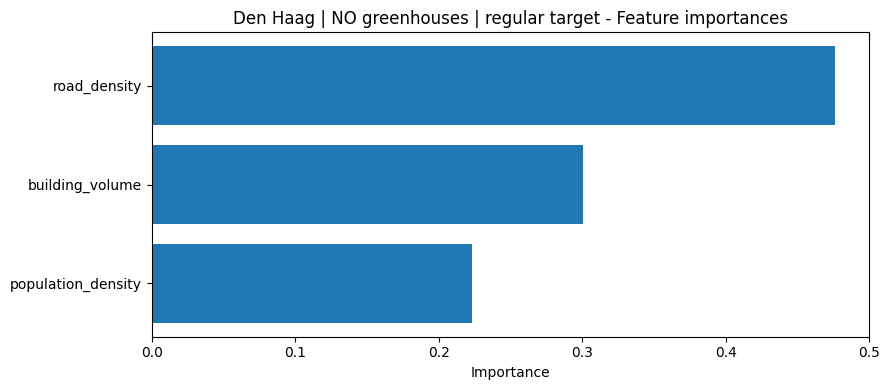


Top 15 importances:
           feature  importance
      road_density    0.476224
   building_volume    0.300805
population_density    0.222971

Den Haag | NO greenhouses | log target
Metric     Value
    R²    0.0241
   MAE  563.6488
  RMSE 2328.2524
OOB R²    0.4345


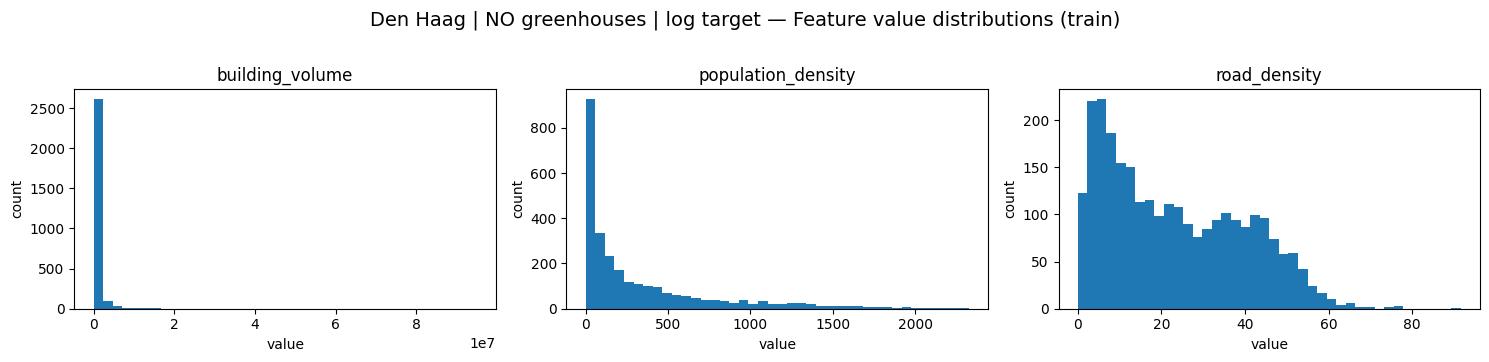

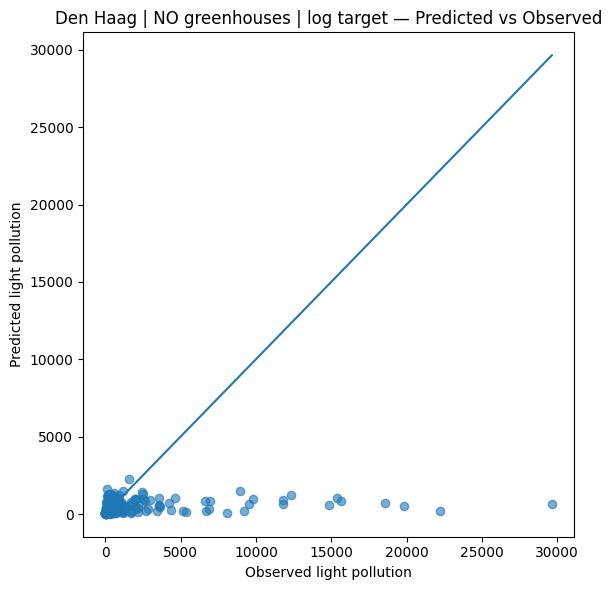

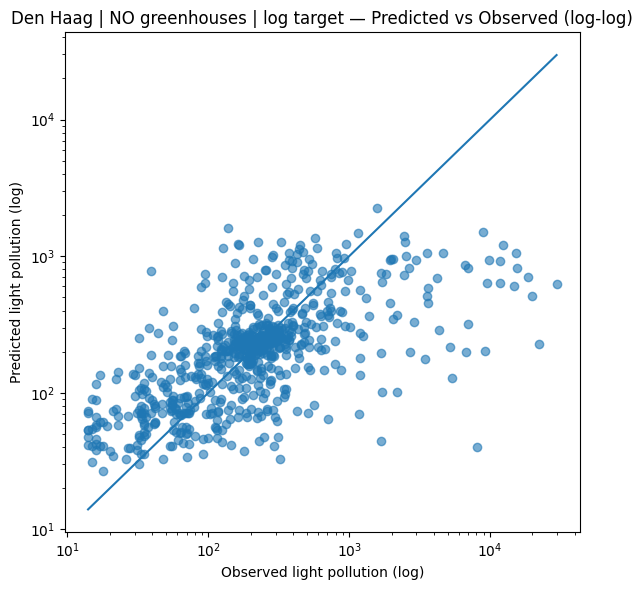

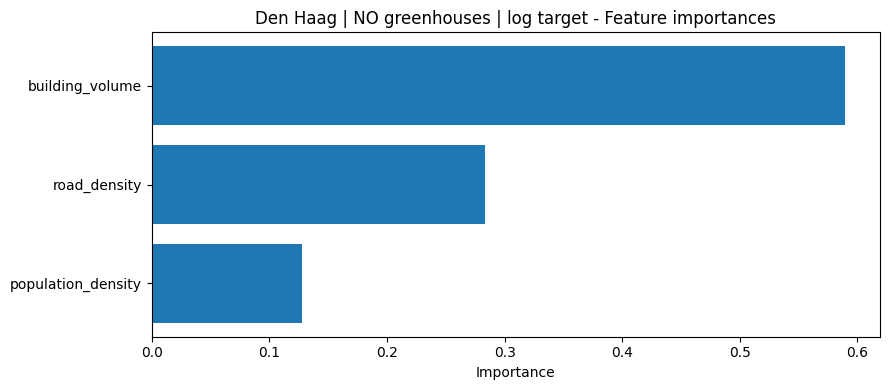


Top 15 importances:
           feature  importance
   building_volume    0.589688
      road_density    0.282954
population_density    0.127358

Den Haag | WITH greenhouses | regular target
Metric     Value
    R²    0.3102
   MAE  557.8117
  RMSE 1957.4170
OOB R²    0.2507


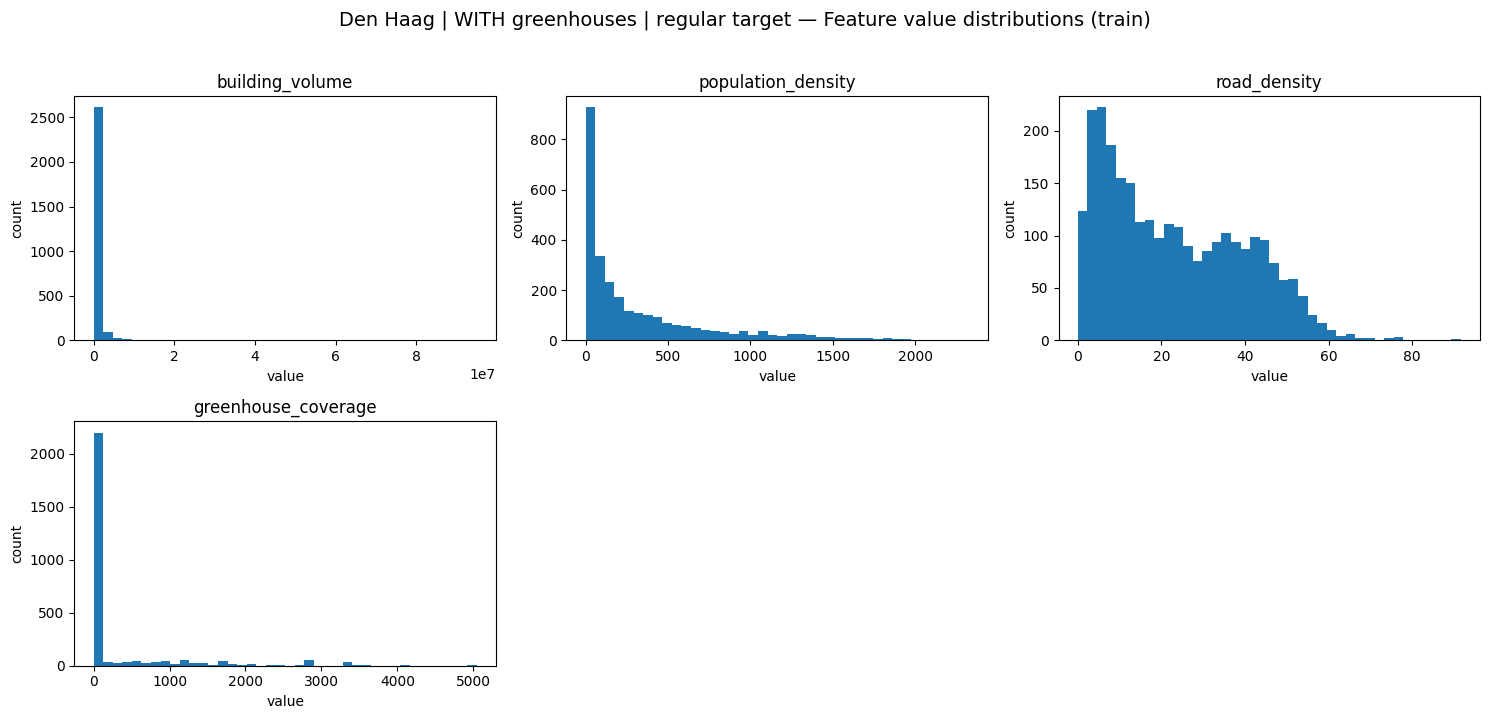

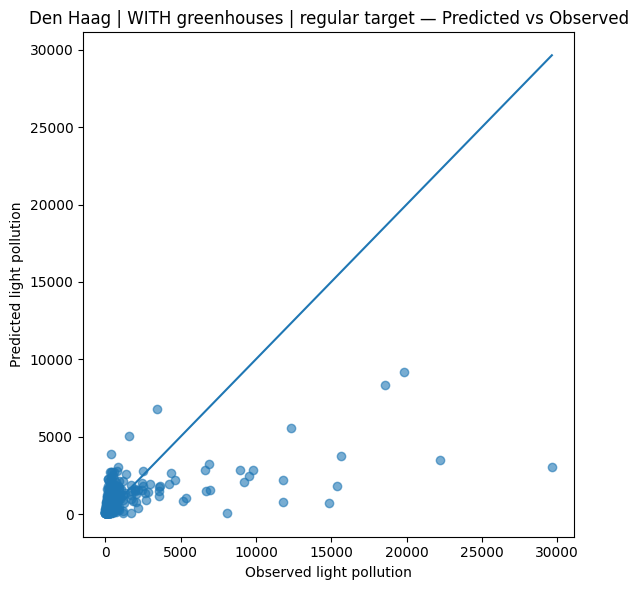

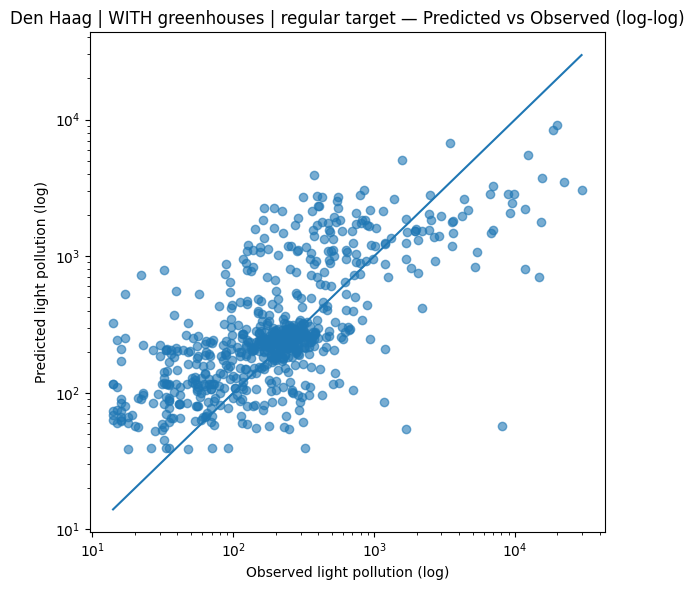

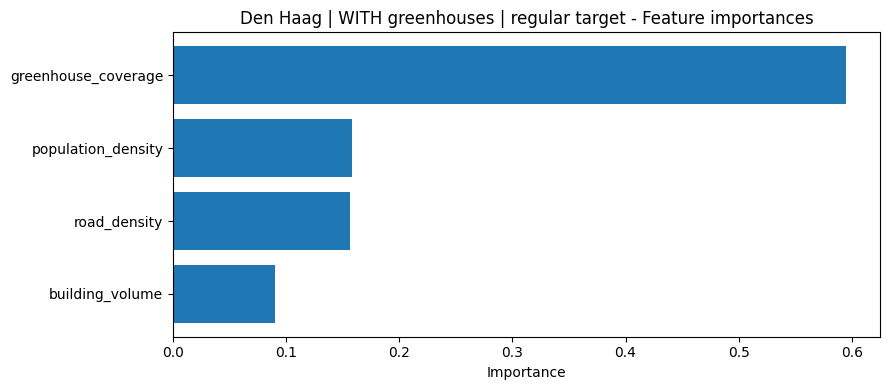


Top 15 importances:
            feature  importance
greenhouse_coverage    0.595256
 population_density    0.157943
       road_density    0.156565
    building_volume    0.090235

Den Haag | WITH greenhouses | log target
Metric     Value
    R²    0.1450
   MAE  513.0010
  RMSE 2179.3021
OOB R²    0.5377


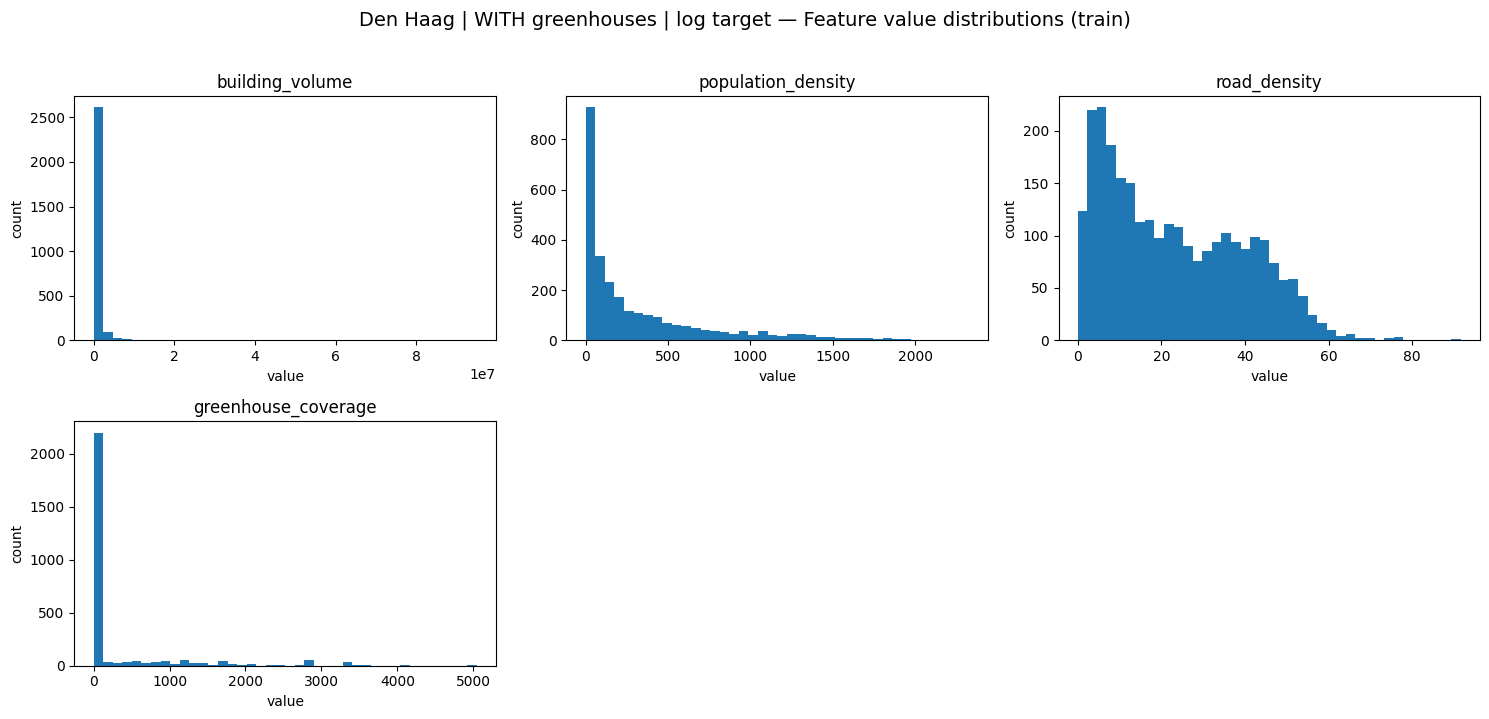

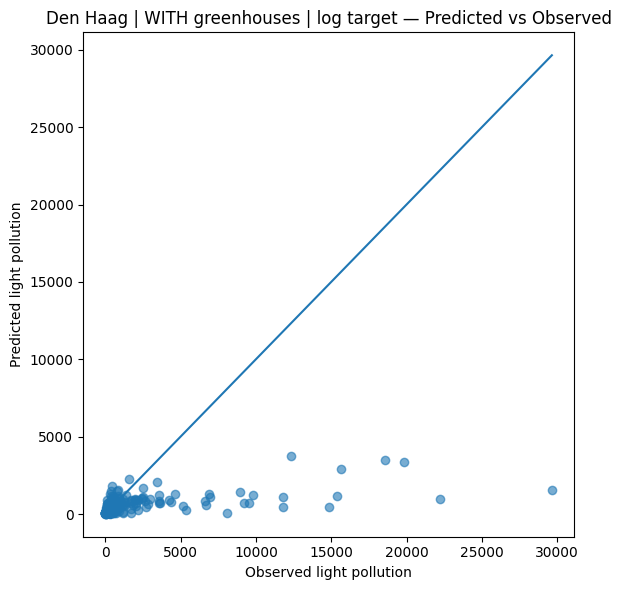

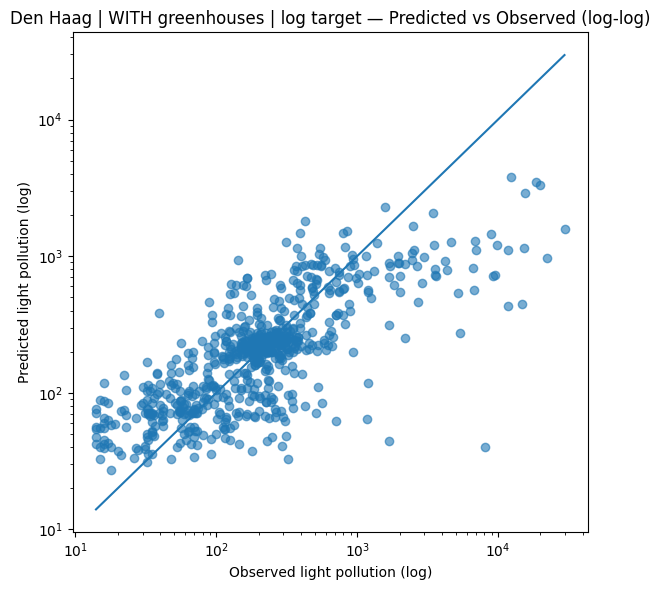

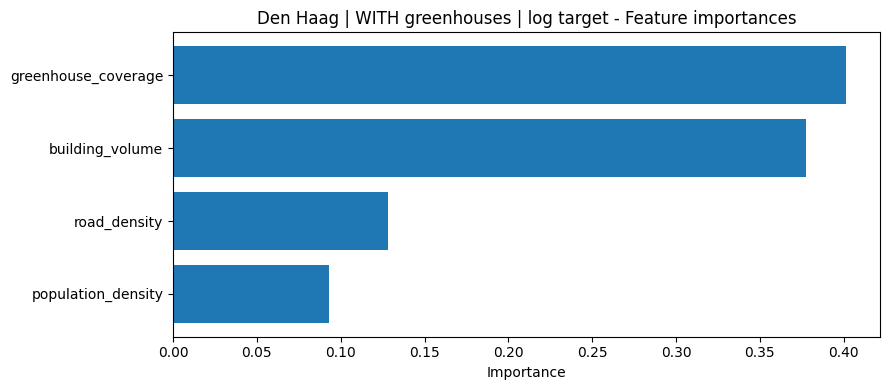


Top 15 importances:
            feature  importance
greenhouse_coverage    0.401656
    building_volume    0.377451
       road_density    0.127990
 population_density    0.092904


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


# -----------------------
# Plot helpers
# -----------------------
def plot_feature_distributions(df_features, features, title, bins=40):
    feats = [f for f in features if f in df_features.columns]
    n = len(feats)
    if n == 0:
        print("No numeric features found to plot distributions.")
        return

    ncols = 3
    nrows = int(np.ceil(n / ncols))
    plt.figure(figsize=(5 * ncols, 3.5 * nrows))

    for i, f in enumerate(feats, start=1):
        ax = plt.subplot(nrows, ncols, i)
        x = df_features[f].dropna().values
        ax.hist(x, bins=bins)
        ax.set_title(f)
        ax.set_xlabel("value")
        ax.set_ylabel("count")

    plt.suptitle(title, y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()


def plot_feature_importances(feature_names, importances, title, top_n=20):
    imp_df = (pd.DataFrame({"feature": feature_names, "importance": importances})
              .sort_values("importance", ascending=False)
              .reset_index(drop=True))

    top = imp_df.head(top_n).iloc[::-1]  # reverse for horizontal bar order
    plt.figure(figsize=(9, max(4, 0.35 * len(top))))
    plt.barh(top["feature"], top["importance"])
    plt.xlabel("Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return imp_df


def regression_metrics(y_true, y_pred, oob=None):
    return pd.DataFrame({
        "Metric": ["R²", "MAE", "RMSE"] + (["OOB R²"] if oob is not None else []),
        "Value": [
            r2_score(y_true, y_pred),
            mean_absolute_error(y_true, y_pred),
            np.sqrt(mean_squared_error(y_true, y_pred)),
        ] + ([oob] if oob is not None else [])
    })


# -----------------------
# Model builder
# -----------------------
def build_model(numeric_features, use_log_target=False):
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric_features)
        ],
        remainder="drop"
    )

    rf = RandomForestRegressor(
        n_estimators=300,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1,
        oob_score=True
    )

    base_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", rf)
    ])

    if not use_log_target:
        return base_pipeline

    log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=False)
    return TransformedTargetRegressor(
        regressor=base_pipeline,
        transformer=log_transformer
    )


# -----------------------
# One experiment runner
# -----------------------
def run_experiment(df_all, city, include_greenhouses, use_log_target, test_size=0.2):
    # Filter city
    df = df_all[df_all["city"] == city].copy()

    # Optionally drop greenhouse columns
    greenhouse_cols = [c for c in df.columns if "greenhouse" in c.lower()]
    if not include_greenhouses:
        df = df.drop(columns=greenhouse_cols)

    # Define X/y
    X = df.drop(columns=["light_pollution", "fid"])
    y = df["light_pollution"]

    # Numeric features: base + optionally greenhouse columns that still exist
    numeric_features = ["building_volume", "population_density", "road_density"]
    if include_greenhouses:
        gh_in_X = [c for c in X.columns if "greenhouse" in c.lower()]
        numeric_features = list(dict.fromkeys(numeric_features + gh_in_X))

    # Sanity check
    missing = [c for c in numeric_features if c not in X.columns]
    if missing:
        raise ValueError(f"[{city}] Missing columns: {missing}")

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    # Build + fit model
    model = build_model(numeric_features, use_log_target=use_log_target)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Extract OOB + feature importances from the underlying RF
    if isinstance(model, TransformedTargetRegressor):
        rf_fitted = model.regressor_.named_steps["model"]
        oob = rf_fitted.oob_score_
        importances = rf_fitted.feature_importances_
    else:
        rf_fitted = model.named_steps["model"]
        oob = rf_fitted.oob_score_
        importances = rf_fitted.feature_importances_

    # Titles
    gh_txt = "WITH greenhouses" if include_greenhouses else "NO greenhouses"
    log_txt = "log target" if use_log_target else "regular target"
    title_prefix = f"{city} | {gh_txt} | {log_txt}"

    # Metrics table
    metrics_df = regression_metrics(y_test, y_pred, oob=oob)
    print("\n" + "=" * 80)
    print(title_prefix)
    print(metrics_df.to_string(index=False, float_format=lambda v: f"{v:.4f}"))

    # 1) Plot feature value distributions (training data only)
    plot_feature_distributions(
        df_features=X_train,
        features=numeric_features,
        title=f"{title_prefix} — Feature value distributions (train)"
    )

    # 2) Predicted vs observed (linear)
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    mn, mx = float(np.min(y_test)), float(np.max(y_test))
    plt.plot([mn, mx], [mn, mx])
    plt.xlabel("Observed light pollution")
    plt.ylabel("Predicted light pollution")
    plt.title(f"{title_prefix} — Predicted vs Observed")
    plt.tight_layout()
    plt.show()

    # Optional log-log diagnostic plot (useful especially when log target=True)
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.xscale("log")
    plt.yscale("log")
    mn_pos = max(float(np.min(y_test[y_test > 0])), 1e-6) if np.any(y_test > 0) else 1e-6
    mx_pos = float(np.max(y_test)) if np.max(y_test) > 0 else 1.0
    plt.plot([mn_pos, mx_pos], [mn_pos, mx_pos])
    plt.xlabel("Observed light pollution (log)")
    plt.ylabel("Predicted light pollution (log)")
    plt.title(f"{title_prefix} — Predicted vs Observed (log-log)")
    plt.tight_layout()
    plt.show()

    # 3) Plot feature importances
    imp_df = plot_feature_importances(
        feature_names=numeric_features,
        importances=importances,
        title=f"{title_prefix} - Feature importances",
        top_n=20
    )
    print("\nTop 15 importances:")
    print(imp_df.head(15).to_string(index=False, float_format=lambda v: f"{v:.6f}"))


# -----------------------
# RUN ALL 8 EXPERIMENTS
# -----------------------
df_all = pd.read_csv("light_pollution_data.csv")

cities = ["Amsterdam", "Den Haag"]
greenhouse_flags = [False, True]   # NO, WITH
log_flags = [False, True]          # regular, log1p

for city in cities:
    for include_greenhouses in greenhouse_flags:
        for use_log_target in log_flags:
            run_experiment(
                df_all=df_all,
                city=city,
                include_greenhouses=include_greenhouses,
                use_log_target=use_log_target
            )




--- Amsterdam | No GH | Regular ---
Metric    Value
    R2   0.3209
   MAE  69.4339
  RMSE 129.2711
OOB_R2   0.3425

--- Amsterdam | No GH | log1p ---
Metric    Value
    R2   0.3539
   MAE  60.2900
  RMSE 126.0897
OOB_R2   0.6106

--- Amsterdam | With GH | Regular ---
Metric    Value
    R2   0.3493
   MAE  68.5682
  RMSE 126.5344
OOB_R2   0.3519

--- Amsterdam | With GH | log1p ---
Metric    Value
    R2   0.3556
   MAE  60.2567
  RMSE 125.9292
OOB_R2   0.6108

--- Den Haag | No GH | Regular ---
Metric     Value
    R2    0.0732
   MAE  671.7740
  RMSE 2268.9968
OOB_R2    0.0605

--- Den Haag | No GH | log1p ---
Metric     Value
    R2    0.0241
   MAE  563.6488
  RMSE 2328.2524
OOB_R2    0.4345

--- Den Haag | With GH | Regular ---
Metric     Value
    R2    0.3102
   MAE  557.8117
  RMSE 1957.4170
OOB_R2    0.2507

--- Den Haag | With GH | log1p ---
Metric     Value
    R2    0.1450
   MAE  513.0010
  RMSE 2179.3021
OOB_R2    0.5377


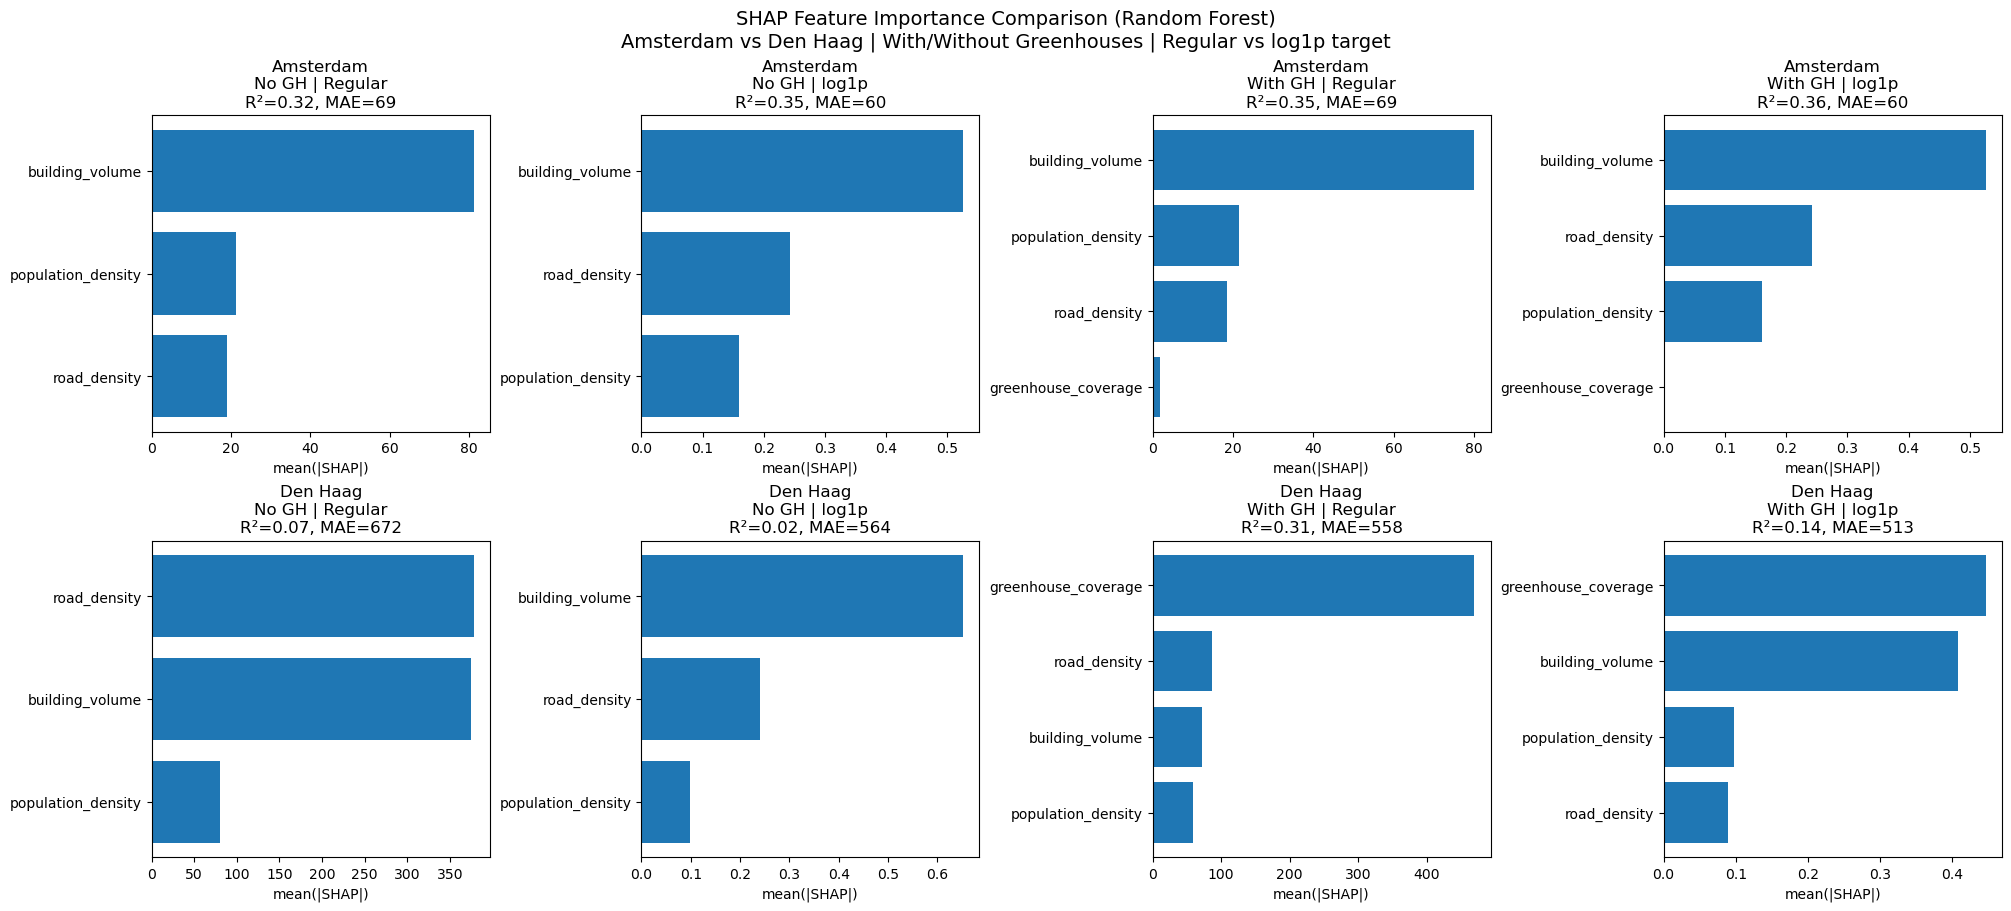


Saved outputs to folder: shap_outputs
Combined grid plot: shap_outputs\shap_grid_bar.png
Beeswarm plots: shap_outputs/beeswarm_*.png


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# --- SHAP import (fails gracefully if not installed) ---
try:
    import shap
except ImportError as e:
    raise ImportError(
        "The 'shap' library is not installed. Install it with: pip install shap"
    ) from e


# =========================
# Config
# =========================
DATA_PATH = "light_pollution_data.csv"
OUT_DIR = "shap_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

RANDOM_STATE = 42
TEST_SIZE = 0.2

BASE_NUMERIC = ["building_volume", "population_density", "road_density"]

CITIES = ["Amsterdam", "Den Haag"]

# 4 conditions per city → total 8 models
CONDITIONS = [
    {"include_greenhouses": False, "log_target": False, "label": "No GH | Regular"},
    {"include_greenhouses": False, "log_target": True,  "label": "No GH | log1p"},
    {"include_greenhouses": True,  "log_target": False, "label": "With GH | Regular"},
    {"include_greenhouses": True,  "log_target": True,  "label": "With GH | log1p"},
]


# =========================
# Helpers
# =========================
def get_greenhouse_cols(df_):
    return [c for c in df_.columns if "greenhouse" in c.lower()]

def select_features(df_city, include_greenhouses):
    """
    Returns (X_df, y_series, feature_list)
    City-only, no categorical encoding (since city constant).
    """
    # Optionally drop greenhouse columns
    df_work = df_city.copy()
    gh_cols = get_greenhouse_cols(df_work)

    if not include_greenhouses and len(gh_cols) > 0:
        df_work = df_work.drop(columns=gh_cols)

    X = df_work.drop(columns=["light_pollution", "fid"])
    y = df_work["light_pollution"]

    features = BASE_NUMERIC.copy()

    if include_greenhouses:
        gh_in_X = [c for c in X.columns if "greenhouse" in c.lower()]
        features = list(dict.fromkeys(features + gh_in_X))

    missing = [c for c in features if c not in X.columns]
    if missing:
        raise ValueError(f"Missing features in X: {missing}")

    return X[features], y, features


def fit_rf_and_shap(X, y, log_target, test_size=0.2, random_state=42, shap_sample=3000):
    """
    Fits RF (on y or log1p(y)), computes SHAP on a subset of test data.
    Returns: fitted_pipeline, X_test_used, shap_values, feature_names, metrics dict.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Target transform
    if log_target:
        y_train_fit = np.log1p(y_train)
        y_test_eval = y_test  # metrics in original units
    else:
        y_train_fit = y_train
        y_test_eval = y_test

    # Simple pipeline: impute -> RF
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("rf", RandomForestRegressor(
            n_estimators=300,
            min_samples_leaf=5,
            random_state=random_state,
            n_jobs=-1,
            oob_score=True
        ))
    ])

    pipe.fit(X_train, y_train_fit)

    # Predict (back-transform if log)
    y_pred = pipe.predict(X_test)
    if log_target:
        y_pred = np.expm1(y_pred)

    # Metrics
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
    metrics = {
        "R2": float(r2_score(y_test_eval, y_pred)),
        "MAE": float(mean_absolute_error(y_test_eval, y_pred)),
        "RMSE": float(np.sqrt(mean_squared_error(y_test_eval, y_pred))),
        "OOB_R2": float(pipe.named_steps["rf"].oob_score_)
    }

    # SHAP computation:
    # Use imputed feature matrix + trained RF.
    X_test_imp = pipe.named_steps["imputer"].transform(X_test)
    feature_names = list(X.columns)

    # sample for speed/clean plots
    if X_test_imp.shape[0] > shap_sample:
        rng = np.random.RandomState(random_state)
        idx = rng.choice(X_test_imp.shape[0], shap_sample, replace=False)
        X_shap = X_test_imp[idx]
    else:
        X_shap = X_test_imp

    rf = pipe.named_steps["rf"]

    # TreeExplainer for RF
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(X_shap)  # regression: array shape (n, p)

    return pipe, X_shap, shap_values, feature_names, metrics


def mean_abs_shap(shap_values):
    return np.mean(np.abs(shap_values), axis=0)


# =========================
# Run all 8 models
# =========================
df = pd.read_csv(DATA_PATH)

results = []  # store per-run info for plotting and reporting

for city in CITIES:
    df_city = df[df["city"] == city].copy()

    for cond in CONDITIONS:
        include_gh = cond["include_greenhouses"]
        log_target = cond["log_target"]
        label = cond["label"]

        X_city, y_city, feats = select_features(df_city, include_gh)

        pipe, X_shap, shap_vals, feat_names, metrics = fit_rf_and_shap(
            X_city, y_city, log_target=log_target,
            test_size=TEST_SIZE, random_state=RANDOM_STATE,
            shap_sample=3000
        )

        results.append({
            "city": city,
            "label": label,
            "include_greenhouses": include_gh,
            "log_target": log_target,
            "feature_names": feat_names,
            "shap_values": shap_vals,
            "metrics": metrics
        })

        print(f"\n--- {city} | {label} ---")
        print(pd.DataFrame({
            "Metric": ["R2", "MAE", "RMSE", "OOB_R2"],
            "Value": [metrics["R2"], metrics["MAE"], metrics["RMSE"], metrics["OOB_R2"]]
        }).to_string(index=False, float_format=lambda v: f"{v:.4f}"))

        # Optional: save a beeswarm per model (nice for appendix)
        # (This can be slow if you have many greenhouse features.)
        plt.figure()
        shap.summary_plot(
            shap_vals, X_shap, feature_names=feat_names,
            plot_type="dot", show=False
        )
        plt.title(f"{city} | {label}")
        plt.tight_layout()
        fname = f"beeswarm_{city.replace(' ','_')}_{label.replace(' ','_').replace('|','')}.png"
        plt.savefig(os.path.join(OUT_DIR, fname), dpi=200)
        plt.close()


# =========================
# Make one "nice graph": 2×4 grid bar charts
# =========================
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 9), constrained_layout=True)

for i, city in enumerate(CITIES):
    for j, cond in enumerate(CONDITIONS):
        ax = axes[i, j]
        label = cond["label"]

        # find matching result
        r = next(
            item for item in results
            if item["city"] == city and item["label"] == label
        )

        shap_vals = r["shap_values"]
        feat_names = r["feature_names"]
        metrics = r["metrics"]

        imp = mean_abs_shap(shap_vals)

        # plot top N
        top_n = min(12, len(feat_names))
        idx = np.argsort(imp)[::-1][:top_n]
        top_feats = [feat_names[k] for k in idx][::-1]
        top_vals = imp[idx][::-1]

        ax.barh(top_feats, top_vals)
        ax.set_title(f"{city}\n{label}\nR²={metrics['R2']:.2f}, MAE={metrics['MAE']:.0f}")
        ax.set_xlabel("mean(|SHAP|)")

plt.suptitle("SHAP Feature Importance Comparison (Random Forest)\nAmsterdam vs Den Haag | With/Without Greenhouses | Regular vs log1p target", fontsize=14)
grid_path = os.path.join(OUT_DIR, "shap_grid_bar.png")
plt.savefig(grid_path, dpi=220)
plt.show()

print(f"\nSaved outputs to folder: {OUT_DIR}")
print(f"Combined grid plot: {grid_path}")
print("Beeswarm plots: shap_outputs/beeswarm_*.png")


Saved PDP+ICE: pdp_ice_Amsterdam_No_GH__Regular.png
Saved PDP+ICE: pdp_ice_Amsterdam_No_GH__log1p.png
Saved PDP+ICE: pdp_ice_Amsterdam_With_GH__Regular.png
Saved PDP+ICE: pdp_ice_Amsterdam_With_GH__log1p.png
Saved PDP+ICE: pdp_ice_Den_Haag_No_GH__Regular.png
Saved PDP+ICE: pdp_ice_Den_Haag_No_GH__log1p.png
Saved PDP+ICE: pdp_ice_Den_Haag_With_GH__Regular.png
Saved PDP+ICE: pdp_ice_Den_Haag_With_GH__log1p.png


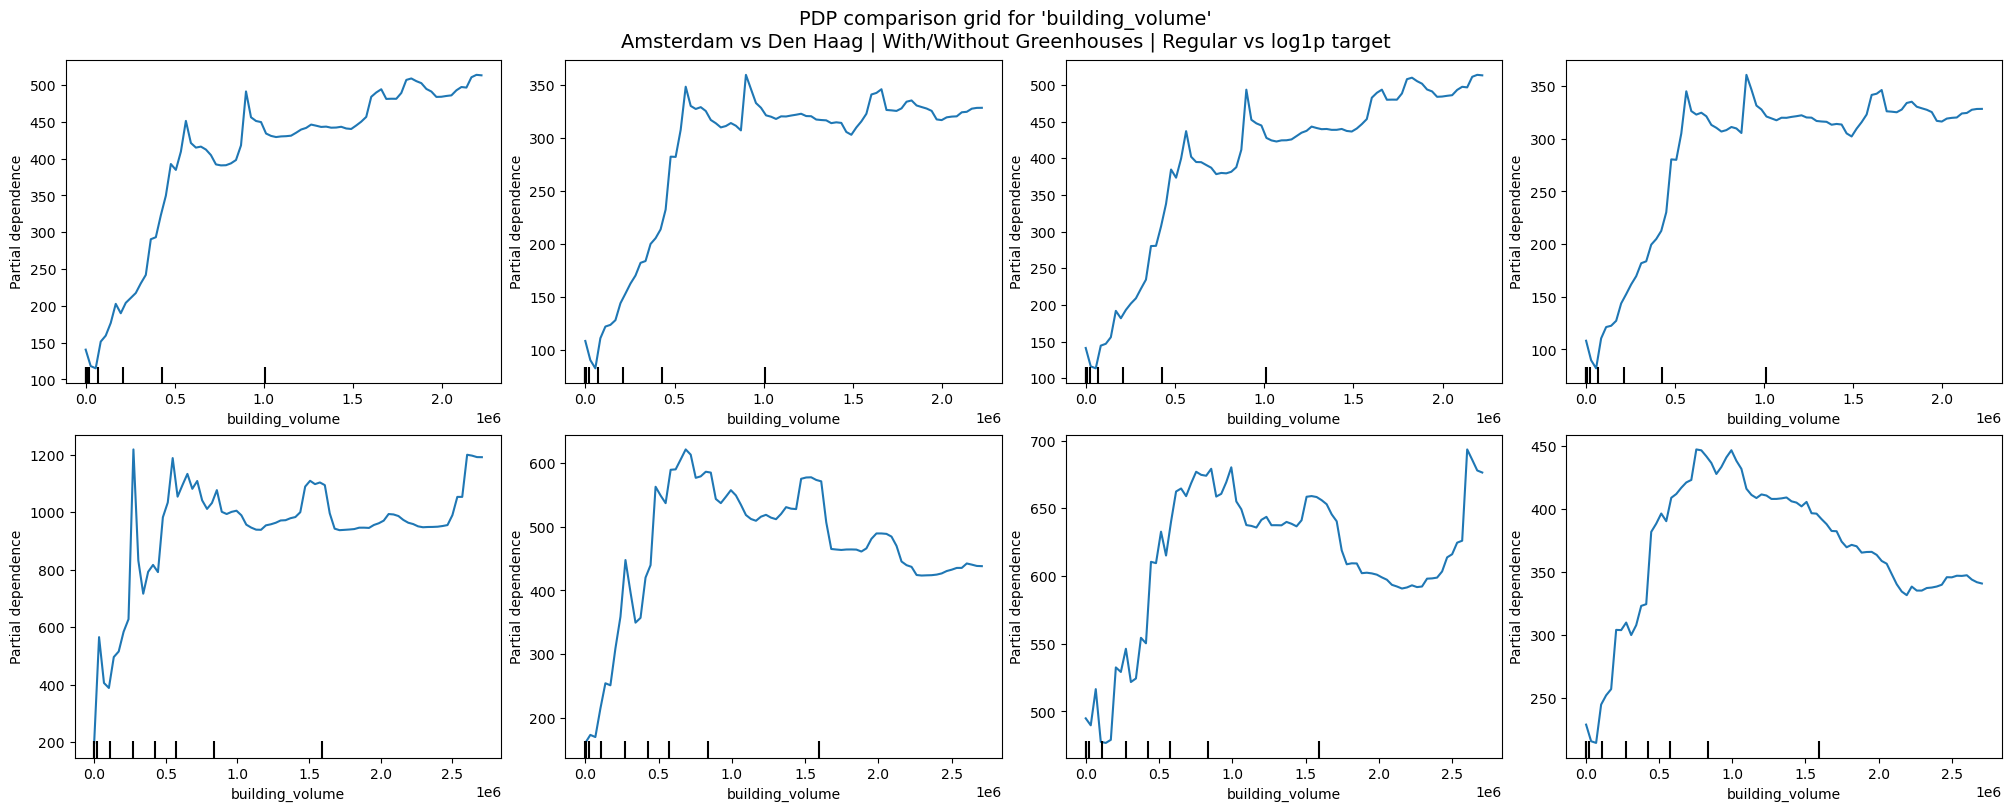


All outputs saved in: pdp_ice_outputs
Grid PDP saved as: pdp_ice_outputs\pdp_grid_building_volume.png
Per-model PDP+ICE saved as: pdp_ice_*.png


In [9]:
"""
PDP + ICE for 8 Random Forest models (city-only):
- Cities: Amsterdam, Den Haag
- Greenhouses: with / without
- Target: regular / log1p

Outputs (saved to pdp_ice_outputs/):
1) A 2×4 PDP grid for one chosen feature (default: building_volume)
2) One PDP+ICE figure per model (multiple features per figure)

Notes:
- n_jobs=1 in PDP/ICE to avoid joblib multiprocessing issues on Windows.
- City-only: we do NOT one-hot encode 'city' because it is constant after filtering.
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.inspection import PartialDependenceDisplay


# =========================
# CONFIG
# =========================
DATA_PATH = "light_pollution_data.csv"
OUT_DIR = "pdp_ice_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

RANDOM_STATE = 42
TEST_SIZE = 0.2

BASE_NUMERIC = ["building_volume", "population_density", "road_density"]
CITIES = ["Amsterdam", "Den Haag"]

# 4 conditions per city → total 8 models
CONDITIONS = [
    {"include_greenhouses": False, "log_target": False, "label": "No GH | Regular"},
    {"include_greenhouses": False, "log_target": True,  "label": "No GH | log1p"},
    {"include_greenhouses": True,  "log_target": False, "label": "With GH | Regular"},
    {"include_greenhouses": True,  "log_target": True,  "label": "With GH | log1p"},
]

# One feature to compare across all 8 scenarios in a clean 2×4 PDP grid:
GRID_FEATURE = "building_volume"  # change to "road_density" if you prefer

# Features to include in per-model PDP+ICE figures:
FEATURES_FOR_PDP_ICE = ["building_volume", "road_density", "population_density"]

# ICE rendering controls (speed/readability):
ICE_SUBSAMPLE = 250      # number of rows used to draw ICE lines (smaller = cleaner/faster)
GRID_RESOLUTION = 60     # PDP grid resolution (higher = smoother but slower)

# Important: avoid multiprocessing in PDP/ICE to prevent BrokenProcessPool on some Windows envs.
PDP_N_JOBS = 1


# =========================
# HELPERS
# =========================
def greenhouse_cols(colnames):
    return [c for c in colnames if "greenhouse" in c.lower()]

def select_city_features(df_city, include_greenhouses):
    """
    City-only dataset: returns (X, y, feature_names)
    - Optionally drops greenhouse columns
    - Uses BASE_NUMERIC + (optional) greenhouse columns
    """
    df_work = df_city.copy()

    gh_cols = greenhouse_cols(df_work.columns)
    if not include_greenhouses and len(gh_cols) > 0:
        df_work = df_work.drop(columns=gh_cols)

    # X/y
    X_all = df_work.drop(columns=["light_pollution", "fid"])
    y = df_work["light_pollution"]

    feats = BASE_NUMERIC.copy()
    if include_greenhouses:
        gh_in_X = greenhouse_cols(X_all.columns)
        feats = list(dict.fromkeys(feats + gh_in_X))  # unique preserve order

    missing = [c for c in feats if c not in X_all.columns]
    if missing:
        raise ValueError(f"Missing features in X: {missing}")

    return X_all[feats], y, feats


def build_estimator(log_target):
    """
    Returns an estimator that predicts in ORIGINAL units.
    - If log_target=False: Pipeline(imputer -> RF)
    - If log_target=True : TransformedTargetRegressor(log1p target, expm1 inverse)
    """
    rf_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("rf", RandomForestRegressor(
            n_estimators=300,
            min_samples_leaf=5,
            random_state=RANDOM_STATE,
            n_jobs=-1,       # RF can be parallel; PDP/ICE will be single-threaded
            oob_score=True
        ))
    ])

    if not log_target:
        return rf_pipe

    log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=False)
    return TransformedTargetRegressor(
        regressor=rf_pipe,
        transformer=log_transformer
    )


def get_underlying_rf(fitted_estimator):
    """Return fitted RF (for OOB + feature importances) from either estimator type."""
    if isinstance(fitted_estimator, TransformedTargetRegressor):
        return fitted_estimator.regressor_.named_steps["rf"]
    return fitted_estimator.named_steps["rf"]


def safe_features(feature_names, desired_list):
    return [f for f in desired_list if f in feature_names]


def plot_and_save_pdp_ice(est, X_train, features, title, outpath):
    """
    Save a multi-panel PDP+ICE figure for a given model.
    """
    n = len(features)
    if n == 0:
        print(f"[SKIP] No features available for PDP/ICE: {title}")
        return

    fig, axes = plt.subplots(1, n, figsize=(5 * n, 4))
    if n == 1:
        axes = [axes]

    for k, f in enumerate(features):
        PartialDependenceDisplay.from_estimator(
            est,
            X_train,
            [f],
            kind="both",                  # PDP + ICE
            subsample=ICE_SUBSAMPLE,      # limit ICE lines for readability/speed
            random_state=RANDOM_STATE,
            n_jobs=PDP_N_JOBS,            # IMPORTANT: avoid multiprocessing issues
            ax=axes[k],
            grid_resolution=GRID_RESOLUTION
        )
        axes[k].set_title(f)

    fig.suptitle(title, y=1.05, fontsize=12)
    plt.tight_layout()
    fig.savefig(outpath, dpi=220, bbox_inches="tight")
    plt.close(fig)


# =========================
# MAIN
# =========================
df = pd.read_csv(DATA_PATH)

# Store fitted runs for the final 2×4 PDP grid
runs = []

for city in CITIES:
    df_city = df[df["city"] == city].copy()

    for cond in CONDITIONS:
        include_gh = cond["include_greenhouses"]
        log_target = cond["log_target"]
        label = cond["label"]

        X, y, feat_names = select_city_features(df_city, include_gh)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
        )

        est = build_estimator(log_target=log_target)
        est.fit(X_train, y_train)

        rf = get_underlying_rf(est)
        oob = float(rf.oob_score_)
        importances = rf.feature_importances_

        # Save for grid plotting
        runs.append({
            "city": city,
            "label": label,
            "include_greenhouses": include_gh,
            "log_target": log_target,
            "estimator": est,
            "X_train": X_train,
            "feature_names": feat_names,
            "oob": oob,
            "importances": importances
        })

        # Choose features for PDP+ICE per model
        chosen = safe_features(feat_names, FEATURES_FOR_PDP_ICE)

        # If greenhouses included, also plot the MOST important greenhouse feature (optional)
        if include_gh:
            gh_feats = greenhouse_cols(feat_names)
            if len(gh_feats) > 0:
                gh_idx = [feat_names.index(g) for g in gh_feats]
                best_gh = gh_feats[int(np.argmax(importances[gh_idx]))]
                if best_gh not in chosen:
                    chosen.append(best_gh)

        # Keep per-model figure readable
        chosen = chosen[:4]

        # Save PDP+ICE figure
        fname = f"pdp_ice_{city.replace(' ', '_')}_{label.replace(' ', '_').replace('|','')}.png"
        outpath = os.path.join(OUT_DIR, fname)
        title = f"{city} | {label} (OOB R²={oob:.2f})"
        plot_and_save_pdp_ice(est, X_train, chosen, title, outpath)

        print(f"Saved PDP+ICE: {fname}")


# =========================
# 2×4 PDP GRID for one feature (clean comparison)
# =========================
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8), constrained_layout=True)

for i, city in enumerate(CITIES):
    for j, cond in enumerate(CONDITIONS):
        label = cond["label"]
        ax = axes[i, j]

        rec = next(r for r in runs if r["city"] == city and r["label"] == label)

        est = rec["estimator"]
        X_train = rec["X_train"]
        feat_names = rec["feature_names"]
        oob = rec["oob"]

        if GRID_FEATURE not in feat_names:
            ax.text(0.5, 0.5, f"{GRID_FEATURE}\n(not in features)", ha="center", va="center")
            ax.set_axis_off()
            continue

        PartialDependenceDisplay.from_estimator(
            est,
            X_train,                 # <-- FIX: use X_train (Xp was never defined)
            [GRID_FEATURE],
            kind="average",          # PDP only for clean grid
            n_jobs=PDP_N_JOBS,       # IMPORTANT: avoid multiprocessing issues
            ax=ax,
            grid_resolution=max(GRID_RESOLUTION, 80)
        )

        ax.set_title(f"{city}\n{label}\nOOB R²={oob:.2f}", fontsize=10)
        ax.set_ylabel("Predicted light pollution")

fig.suptitle(
    f"PDP comparison grid for '{GRID_FEATURE}'\nAmsterdam vs Den Haag | With/Without Greenhouses | Regular vs log1p target",
    fontsize=14
)

grid_path = os.path.join(OUT_DIR, f"pdp_grid_{GRID_FEATURE}.png")
fig.savefig(grid_path, dpi=240, bbox_inches="tight")
plt.show()

print(f"\nAll outputs saved in: {OUT_DIR}")
print(f"Grid PDP saved as: {grid_path}")
print("Per-model PDP+ICE saved as: pdp_ice_*.png")
